# Load libraries and Data files

In [7]:
from sklearn.model_selection import train_test_split
import copy 
import datetime
import statistics
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import random
import math
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [8]:
# Load data
df_train1 = pd.read_csv('/Users/amanprasad/Documents/Kaggle/Web_Traffic_Time_Series_Forecasting/web-traffic-time-series-forecasting/train_1.csv')
df_train1.shape

(145063, 551)

In [9]:
df_key1 = pd.read_csv('/Users/amanprasad/Documents/Kaggle/Web_Traffic_Time_Series_Forecasting/web-traffic-time-series-forecasting/key_1.csv')
df_key1.shape

(8703780, 2)

In [10]:
train=copy.deepcopy(df_train1) 
key=copy.deepcopy(df_key1)

# Some Basic Functions used

In [11]:
# missing data count column wise
def null_val_desc(dataframe_name):
    null_all=dataframe_name.isnull().sum()
    null_all_desc=null_all[null_all>0].sort_values(ascending = False) 
    null_all_desc=pd.DataFrame(null_all_desc)
    null_all_desc = null_all_desc.reset_index()
    null_all_desc.columns = ['column', 'missing_count']
    return null_all_desc

#-------------------------------------------------------------------------------------------------------------
# calculate slope and its standard error from linear regression
def standard_error_coef_linear_reg(X,y):
    import pandas as pd
    import numpy as np
    from sklearn import linear_model
    model = linear_model.LinearRegression()
    model.fit(X=X, y=y)
    
    #print("from scikit-learn")
    #print('Intercept = {I}'.format(I=model.intercept_))
    #print('Model Coefficient = {C}'.format(C=model.coef_))

    N = len(X)
    p = len(X.columns) + 1
    
    X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:p] = X.values
    
    beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y.values
    #print('Standard Error Intercept(1st) and Coefficients = {S}'.format(S=beta_hat))
    return [beta_hat,model.coef_]

#-------------------------------------------------------------------------------------------------------------
def kde_plot_with_hue(dataframe,column_to_plot,hue):
    #return dataframe[column_to_plot]
    gr = dataframe.groupby(hue)[column_to_plot]
    for label, arr in gr:
        a=sns.kdeplot(arr, label=label, shade=True)
    a.set(title='KDE plot: {v}'.format(v=column_to_plot),xlabel=column_to_plot,ylabel='density')

#-------------------------------------------------------------------------------------------------------------
# find missing values in columns
def missing_value(dataFrame):
    null_all=dataFrame.isnull().sum()
    
    null_all_desc=null_all[null_all>0].sort_values(ascending = False) 
    
    null_all_desc=pd.DataFrame(null_all_desc)
    null_all_desc = null_all_desc.reset_index()
    null_all_desc.columns = ['column', 'missing_count']
    return (null_all_desc)

#-------------------------------------------------------------------------------------------------------------
# find missing values in row
def missing_value_rowWise(dataframe):
    miss=[]
    rowname=[]
    for i in range(len(dataframe.index)) :
        miss.append(dataframe.iloc[i].isnull().sum())
        rowname.append(i)
    miss=np.array(miss)   
    data = {'rowname':rowname, 'count_missing_val':miss}
    # Create DataFrame 
    df = pd.DataFrame(data)
    return df

#-------------------------------------------------------------------------------------------------------------
# get days- enter the dataframe- there should be a column 'dates'
def weekdayName_views(dataframe):
    for i in dataframe.index:
        d=dataframe.loc[i,['dates']][0]
        week_num = d.weekday()
        weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
        week_num_asName = weekDays[week_num]
        dataframe.loc[i,['dates']]=week_num_asName
    return dataframe

#-------------------------------------------------------------------------------------------------------------
def weekDay_views(rownr,startDate,endDate):
    foo1=extract_ts(rownr)
    foo1=foo1[(foo1['dates']>startDate)&(foo1['dates']<endDate)]
    weekdayName_views(foo1)
    foo2=foo1.groupby(['dates']).mean()
    foo2['wday_views']=foo2['views']/np.mean(foo2['views'])
    foo2['id']=rownr
    foo2.drop(['views'],axis=1,inplace=True)
    foo2.reset_index(inplace=True)
    foo2['dates']=foo2['dates'].astype('category')
    foo2['dates']=foo2['dates'].cat.reorder_categories(["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"], ordered=True)
    foo2=foo2.sort_values(by=['dates'])
    foo2.reset_index(drop=True,inplace=True)    
    return foo2

Missing values in train

In [12]:
null_val=null_val_desc(train)
miss_val=null_val['missing_count'].sum()/(train.shape[0]*train.shape[1])*100
print('percentage of data missing = {m}'.format(m=miss_val))

percentage of data missing = 7.747971020488964


# Data transformation and helper functions

#### Article names and metadata

To make the training data easier to handle we split it into two part: the article information (from the Page column) and the time series data (tdates) from the date columns. We briefly separate the article information into data from wikipedia, wikimedia, and mediawiki due to the different formatting of the Page names. After that, we rejoin all article information into a common data set (tpages).

In [13]:
tdates=train.loc[:,~train.columns.isin(['Page'])]

foo=pd.DataFrame(data= train.loc[:,'Page'],columns=['Page'])
foo['rowname'] = foo.index
foo = foo[['rowname', 'Page']]

mediawiki=foo[foo['Page'].str.contains("mediawiki")]
wikimedia=foo[foo['Page'].str.contains("wikimedia")]

wikipedia=foo[~foo['Page'].str.contains("wikimedia")]
wikipedia=wikipedia[~wikipedia['Page'].str.contains("mediawiki")]

#-----------------------------------------------------
# creating wikipedia dataframe
new = wikipedia["Page"].str.split(".wikipedia.org_", expand = True) 
article=new.iloc[:,0].str[:-3]
locale=new.iloc[:,0].str[-2:]
new1 = new.iloc[:,1].str.split("_", expand = True)

# combining all
wikipedia['article']=article
wikipedia['locale']=locale
wikipedia['access']=new1.iloc[:,0]
wikipedia['agent']=new1.iloc[:,1]

# remove Page column from wikipedia
wikipedia.drop(['Page'],axis=1,inplace=True)

#-----------------------------------------------------
# creating wikimedia dataframe
new = wikimedia["Page"].str.split("_commons.wikimedia.org_", expand = True) 
new1 = new.iloc[:,1].str.split("_", expand = True)
wikimedia['article']=new.iloc[:,0]
wikimedia['access']=new1.iloc[:,0]
wikimedia['agent']=new1.iloc[:,1]
wikimedia['locale']='wikmed'

# remove Page column from wikimedia
wikimedia.drop(['Page'],axis=1,inplace=True)

#-----------------------------------------------------
# creating mediawiki dataframe
new = mediawiki["Page"].str.split("_www.mediawiki.org_", expand = True) 
new1 = new.iloc[:,1].str.split("_", expand = True)
mediawiki['article']=new.iloc[:,0]
mediawiki['access']=new1.iloc[:,0]
mediawiki['agent']=new1.iloc[:,1]
mediawiki['locale']='medwik'

# remove Page column from mediawiki
mediawiki.drop(['Page'],axis=1,inplace=True)

#-----------------------------------------------------
# combining wikipedia, wikimedia, mediawiki
frames = [wikipedia, wikimedia, mediawiki]
tpages = pd.concat(frames)
tpages.reset_index(drop=True,inplace=True)

# Time series extraction

In order to plot the time series data we use a helper function that allows us to extract the time series for a specified row number. (The normalised version is to facilitate the comparision between multiple time series curves, to correct for large differences in view count.)

In [14]:
def extract_ts(rownr):
    df=pd.DataFrame(data=tdates.iloc[rownr,:])
    df=df.reset_index()
    df=df.rename(columns={"index": "dates", rownr: "views"})
    df['dates']= pd.to_datetime(df['dates'],format='%Y-%m-%d')
    return df

def extract_ts_nrm(rownr):
    df=pd.DataFrame(data=tdates.iloc[rownr,:])
    df=df.reset_index()
    df=df.rename(columns={"index": "dates", rownr: "views"})
    df['dates']= pd.to_datetime(df['dates'],format='%Y-%m-%d')
    df['views']=df['views']/df['views'].mean()
    return df

A custom-made plotting function allows us to visualise each time series and extract its meta data:

In [15]:
def plot_rownr(rownr):
    art=tpages.loc[tpages['rowname'] == rownr, 'article'].iloc[0]
    loc=tpages.loc[tpages['rowname'] == rownr, 'locale'].iloc[0]
    acc=tpages.loc[tpages['rowname'] == rownr, 'access'].iloc[0]
    b=extract_ts(rownr)
    b.set_index('dates',inplace=True)
    b['views: 30 Day Mean'] = b['views'].rolling(window=30).mean()
    title=('{a}-{l}-{ac}'.format(a=art,l=loc ,ac=acc))
    ax=b[['views','views: 30 Day Mean']].plot(title=title,figsize=(16,6)).autoscale(axis='x',tight=True)    
    
def plot_rownr_log(rownr):
    art=tpages.loc[tpages['rowname'] == rownr, 'article'].iloc[0]
    loc=tpages.loc[tpages['rowname'] == rownr, 'locale'].iloc[0]
    acc=tpages.loc[tpages['rowname'] == rownr, 'access'].iloc[0]
    b=extract_ts_nrm(rownr)
    b.set_index('dates',inplace=True)
    b['log(views)']=np.log(b['views'])
    b['log(views): 30 Day Mean'] = b['log(views)'].rolling(window=30).mean()
    title=('{a}-{l}-{ac}'.format(a=art,l=loc ,ac=acc))
    ax=b[['log(views)','log(views): 30 Day Mean']].plot(title=title,figsize=(16,6)).autoscale(axis='x',tight=True)

def plot_rownr_zoom(rownr, start, end):
    art=tpages.loc[tpages['rowname'] == rownr, 'article'].iloc[0]
    loc=tpages.loc[tpages['rowname'] == rownr, 'locale'].iloc[0]
    acc=tpages.loc[tpages['rowname'] == rownr, 'access'].iloc[0]
    b=extract_ts(rownr)
    b.set_index('dates',inplace=True)
    b['views: 30 Day Mean'] = b['views'].rolling(window=30).mean()
    title=('{a}-{l}-{ac}'.format(a=art,l=loc ,ac=acc))
    b[['views','views: 30 Day Mean']].plot(title=title,xlim=[start,end],figsize=(16,6))

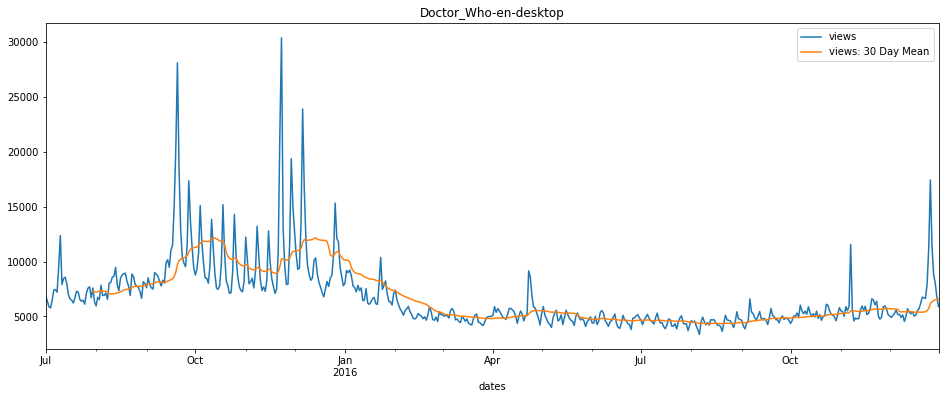

In [16]:
plot_rownr(11213)

In addition, with the help of the extractor tool we define a function that re-connects the Page information to the corresponding time series and plots this curve according to our specification on article name, access type, and agent for all the available languages:

In [17]:
def plot_names(art, acc, ag):
    pick=tpages[(tpages['article']==art)&(tpages['access']==acc)&(tpages['agent']==ag)]
    pick_nr=pick['rowname']
    pick_loc=pick['locale']
    foo=extract_ts(pick.index[0])
    foo['loc']=pick_loc[pick.index[0]]
    
    for i in range(1,len(pick.index)):
        foo1=extract_ts(pick_nr.iloc[i])
        foo1['loc']=pick_loc.iloc[i]
        foo=pd.concat([foo,foo1])
    
    plt.figure(figsize=(16, 6))
    sns.lineplot(x='dates',y='views',data=foo,hue='loc').set_title(art+'-'+acc+'-'+ag)

def plot_names_nrm(art, acc, ag):
    pick=tpages[(tpages['article']==art)&(tpages['access']==acc)&(tpages['agent']==ag)]
    pick_nr=pick['rowname']
    pick_loc=pick['locale']
    foo=extract_ts(pick.index[0])
    foo['loc']=pick_loc[pick.index[0]]
    
    for i in range(1,len(pick.index)):
        foo1=extract_ts(pick_nr.iloc[i])
        foo1['loc']=pick_loc.iloc[i]
        foo=pd.concat([foo,foo1])
        
    foo['log(views)']=np.log(foo['views'])
    plt.figure(figsize=(16, 6))
    sns.lineplot(x='dates',y='log(views)',data=foo,hue='loc').set_title(art+'-'+acc+'-'+ag)

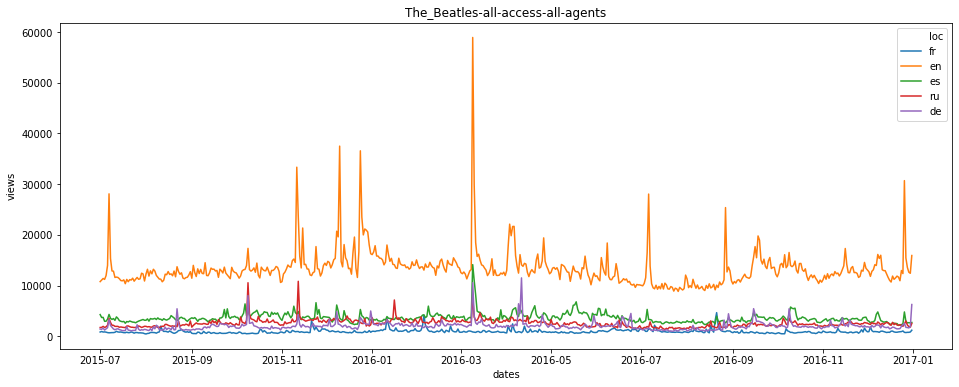

In [18]:
plot_names("The_Beatles", "all-access", "all-agents")

These are the tools we need for a visual examinination of arbitrary individual time series data. In the following, we will use them to illustrate specific observations that are of particular interest.

# Summary parameter extraction

In the next step we will have a more global look at the population parameters of our training time series data. Also here, we will start with the wikipedia data. The idea behind this approach is to probe the parameter space of the time series information along certain key metrics and to identify extreme observations that could break our forecasting strategies.  

## Projects data overview

Before diving into the time series data let’s have a look how the different meta-parameters are distributed:

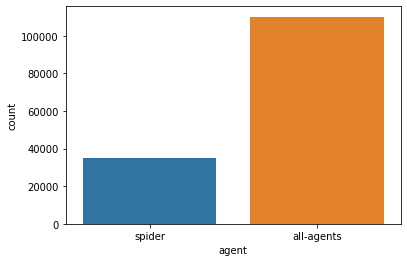

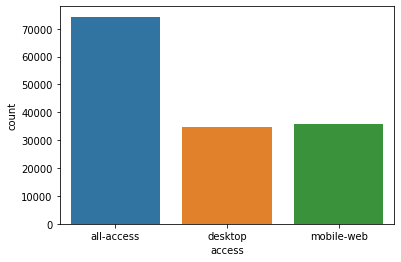

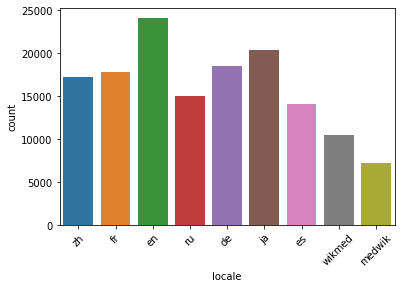

In [19]:
sns.countplot('agent',data=tpages)
plt.show()

sns.countplot('access',data=tpages)
plt.show()

chart1=sns.countplot('locale',data=tpages)
chart1.set_xticklabels(chart1.get_xticklabels(), rotation=45)
plt.show()

We find that our wikipedia data includes 7 languages: German, English, Spanish, French, Japanese, Russian, and Chinese. All of those are more frequent than the mediawiki and wikimedia pages. Mobile sites are slightly more frequent than desktop ones.

## Basic time series parameters

We start with a basic set of parameters: mean, standard deviation, amplitude, and a the slope of a naive linear fit. This is our extraction function:

In [20]:
def params_ts1(rownr):
    foo=tdates.iloc[rownr,:]
    foo=foo.reset_index()
    foo=foo.rename(columns={"index": "dates", rownr: "views"})
    foo['dates']= pd.to_datetime(foo['dates'],format='%Y-%m-%d')
    
    foo['1']=foo['views']
    foo=foo[['dates','1','views']]
    
    #foo['views']=foo['views'].fillna(0)
    
    min_view=np.min(foo['views'])
    max_view=np.max(foo['views'])
    mean_view=np.mean(foo['views'])
    med_view = np.median(foo['views'])
    sd_view = statistics.stdev(foo['views'])
    
    dd_vv=copy.deepcopy(foo)
    dd_vv['views']=dd_vv['views'].fillna(0)
    dd=pd.DataFrame(dd_vv['dates'])
    vv=pd.DataFrame(dd_vv['views'])
    
    sd_error=np.array(standard_error_coef_linear_reg(dd,vv))
    slope=sd_error[0][1][0]
    
    data = {'rowname':rownr,'min_view':[min_view], 'max_view':[max_view],'mean_view':[mean_view],'med_view':[med_view],'sd_view':[sd_view],'slope':[slope]} 
    # Create DataFrame 
    df = pd.DataFrame(data)
    ind=pd.Series([rownr])
    df.set_index(ind,inplace=True)
    return df

In [ ]:
foo=copy.deepcopy(tpages)

In [29]:
# exporting df_train_noNull21 into csv as above operation take a long time
#params_original.to_csv(r'/Users/amanprasad/Documents/Kaggle/Web_Traffic_Time_Series_Forecasting/Files_WebViews/params_original.csv', index = False)

In [32]:
# Load params
params = pd.read_csv('/Users/amanprasad/Documents/Kaggle/Web_Traffic_Time_Series_Forecasting/Files_WebViews/params_original.csv')
params

rowname  min_view  max_view  mean_view  med_view    sd_view  \
0             0       3.0     490.0  21.756364      16.0  29.390758   
1             1       2.0     621.0  25.392727      17.0  33.984813   
2             2       0.0     210.0   5.203636       4.0  13.505932   
3             3       1.0     303.0  17.125455      13.0  19.337118   
4             4       0.0     234.0  10.277992       NaN        NaN   
...         ...       ...       ...        ...       ...        ...   
145058    84730       0.0     355.0  14.204082       NaN        NaN   
145059    84731       0.0     743.0  36.455210       NaN        NaN   
145060    84732       0.0     797.0  39.358834       NaN        NaN   
145061    84733       0.0    1811.0  40.890741       NaN        NaN   
145062    84734       0.0    1313.0  39.640000       NaN        NaN   

               slope  
0       2.850414e-16  
1       2.510084e-16  
2       8.393466e-17  
3       6.779094e-17  
4       3.420080e-16  
...              ...  
145058  1.266445e-16  
145059  3.475281e-16  
145060  1.894346e-16  
145061  4.349847e-16  
145062  6.115940e-16  

[145063 rows x 7 columns]

In [33]:
#removing values
# droppping all the rows related to articles which has no views ever
article_allZeroView_index=params[params['mean_view']==0].index
article_allZeroView_rowname=params[params['mean_view']==0][['rowname']]

params.drop(labels=None, axis=0, index=article_allZeroView_index, columns=None, level=None, inplace=True, errors='raise')

params[(params['mean_view']<0)|(params['sd_view']<0)|(params['min_view']<0)|(params['max_view']<0)|(params['med_view']<0)]
# so no negative value

params[params['sd_view']==0].index
params[params['max_view']==0].index

missing_value(params)

mean_view_missing_index=params[params['mean_view'].isnull()].index
params.drop(labels=None, axis=0, index=mean_view_missing_index, columns=None, level=None, inplace=True, errors='raise')

params.reset_index(drop=True,inplace=True)

In [84]:
params

rowname  min_view  max_view  mean_view  med_view    sd_view  \
0             0       3.0     490.0  21.756364      16.0  29.390758   
1             1       2.0     621.0  25.392727      17.0  33.984813   
2             2       0.0     210.0   5.203636       4.0  13.505932   
3             3       1.0     303.0  17.125455      13.0  19.337118   
4             4       0.0     234.0  10.277992       NaN        NaN   
...         ...       ...       ...        ...       ...        ...   
144306    84730       0.0     355.0  14.204082       NaN        NaN   
144307    84731       0.0     743.0  36.455210       NaN        NaN   
144308    84732       0.0     797.0  39.358834       NaN        NaN   
144309    84733       0.0    1811.0  40.890741       NaN        NaN   
144310    84734       0.0    1313.0  39.640000       NaN        NaN   

               slope  
0       2.850414e-16  
1       2.510084e-16  
2       8.393466e-17  
3       6.779094e-17  
4       3.420080e-16  
...              ...  
144306  1.266445e-16  
144307  3.475281e-16  
144308  1.894346e-16  
144309  4.349847e-16  
144310  6.115940e-16  

[144311 rows x 7 columns]

In [35]:
# missing value row/website wise
miss_val_tdates=missing_value_rowWise(tdates)

In [36]:
# printing the start and end dates of an article
sd_view_miss_rowname=params[params['sd_view'].isnull()]['rowname']

article_startDate=[]
rown_1=[]
for j in range(tdates.shape[0]):
    for i in range(0,tdates.shape[1]):
        if (math.isnan(tdates.iloc[j,i])==False):
            rown_1.append(j)
            article_startDate.append(tdates.columns[i])
            break

article_endDate=[]
rown_2=[]
for j in range(tdates.shape[0]):
    for i in reversed(range(tdates.shape[1])):
        if (math.isnan(tdates.iloc[j,i])==False):
            rown_2.append(j)
            article_endDate.append(tdates.columns[i])
            break

data={'rowname':rown_1,'article_startDate':article_startDate,'article_endDate':article_endDate}
article_start_end_Date=pd.DataFrame(data)

# exporting article_start_end_Date into csv
#article_start_end_Date.to_csv(r'/Users/amanprasad/Documents/Kaggle/Web_Traffic_Time_Series_Forecasting/Files_WebViews/article_start_end_Date.csv', index = False)

# Overview visualisations

Let’s explore the parameter space we’ve built. First we plot the histograms of our main parameters:

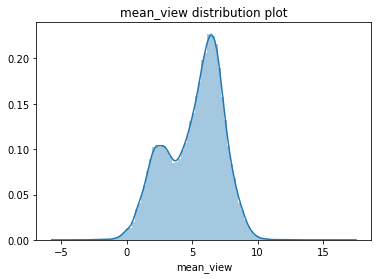

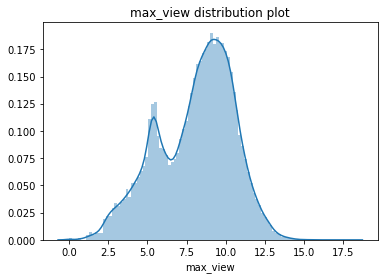

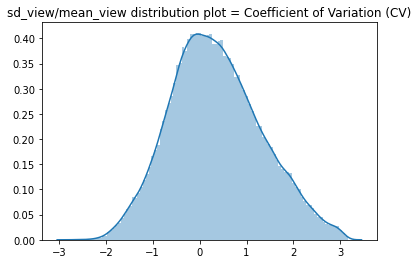

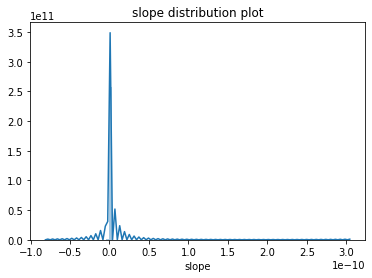

In [37]:
ax=sns.distplot(np.log(params['mean_view']),bins=100)
ax.set(title='mean_view distribution plot')
plt.show()

#--------------------------------
ax=sns.distplot(np.log(params['max_view']),bins=100)
ax.set(title='max_view distribution plot')
plt.show()

#--------------------------------
#Coefficient of Variation (CV)
#If you know nothing about the data other than the mean, one way to interpret the relative magnitude of the standard deviation 
#is to divide it by the mean. This is called the coefficient of variation. For example, if the mean is 80 and standard deviation 
#is 12, the cv = 12/80 = .15 or 15%.
#If the standard deviation is .20 and the mean is .50, then the cv = .20/.50 = .4 or 40%. So knowing nothing else about the data, 
#the CV helps us see that even a lower standard deviation doesn't mean less variable data.
#Hence it helps a lot with understanding relative variability.

ax=sns.distplot(np.log(params['sd_view']/params['mean_view']),bins=100)
ax.set(title='sd_view/mean_view distribution plot = Coefficient of Variation (CV)')
plt.show()

#---------------------------------
ax=sns.distplot((params['slope']),bins=100)
ax.set(title='slope distribution plot')
plt.show()

We find:

1.The distribution of average views is clearly bimodal, with peaks around 3 and 8 views. Something similar is true for the number of maximum views.

2.The distribution of standard deviations (divided by the mean) is skewed toward higher values with larger numbers of spikes or stronger variability trends. Those will be the observations that are more challenging to forecast.

3.The slope distribution is resonably symmetric and centred notably above zero.


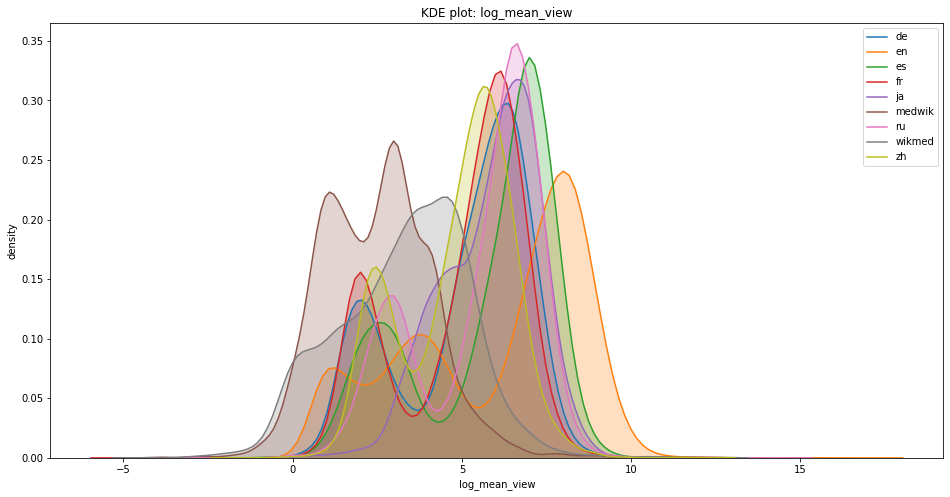

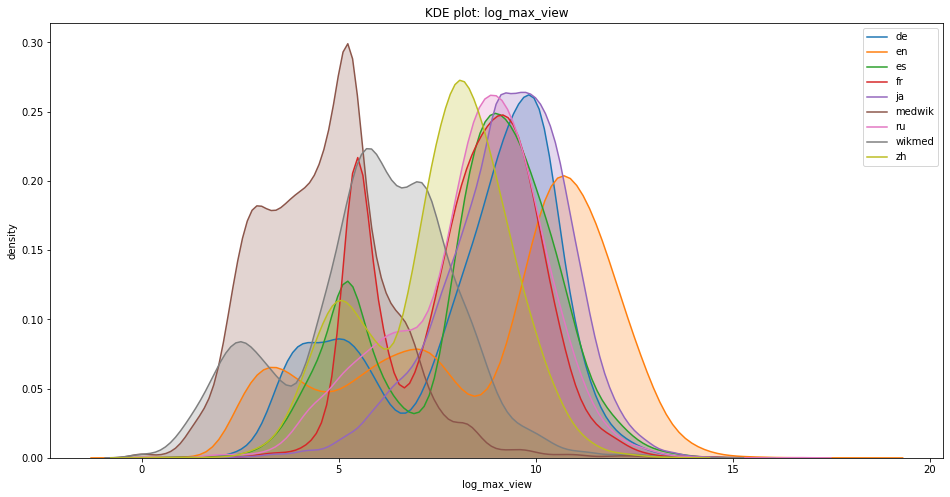

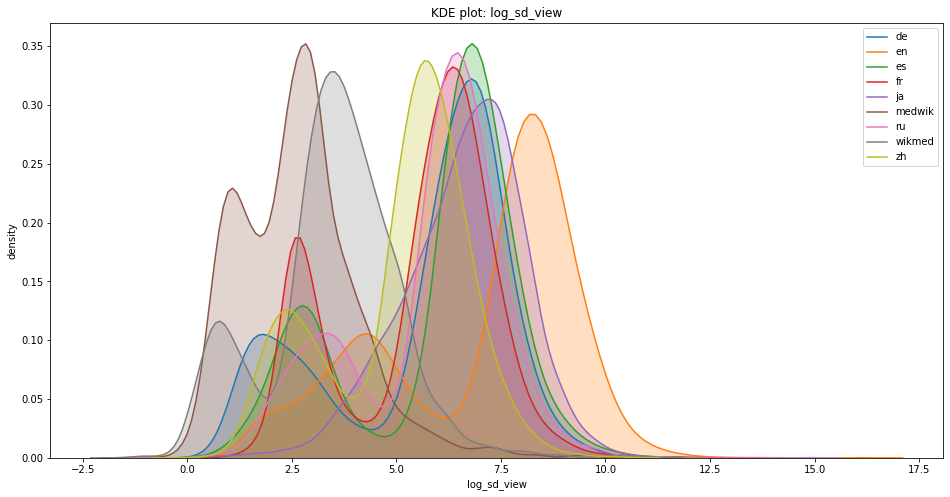

In [38]:
#Let’s split it up by locale and focus on the densities:
params1=copy.deepcopy(params)

par_page = pd.merge(params1,tpages,on='rowname', how='left')
par_page['log_mean_view']=np.log(par_page['mean_view'])
par_page['log_max_view']=np.log(par_page['max_view'])
par_page['log_sd_view']=np.log(par_page['sd_view'])

# function for kde plot with hue
def kde_plot_with_hue(dataframe,column_to_plot,hue):
    #return dataframe[column_to_plot]
    gr = dataframe.groupby(hue)[column_to_plot]
    for label, arr in gr:
        #sns.set(color_codes=True)
        a=sns.kdeplot(arr, label=label, shade=True)
    a.set(title='KDE plot: {v}'.format(v=column_to_plot),xlabel=column_to_plot,ylabel='density')
    
plt.figure(figsize=(16, 8))
kde_plot_with_hue(par_page,'log_mean_view','locale')
plt.show()

plt.figure(figsize=(16, 8))
kde_plot_with_hue(par_page,'log_max_view','locale')
plt.show()

plt.figure(figsize=(16, 8))
kde_plot_with_hue(par_page,'log_sd_view','locale')
plt.show()

We find:

1.The chinese pages (zh) are slightly but notably different from the rest. The have lower mean and max views and also less variation. Their slope distribution is broader, but also shifted more towards positive values compared to the other curves.

2.The peak in max views in earlier stage is most pronounced in the french pages (fr).

3.The english pages (en) have the highest mean and maximum views, which is not surprising.

Next, we will examine binned 2-d histograms.

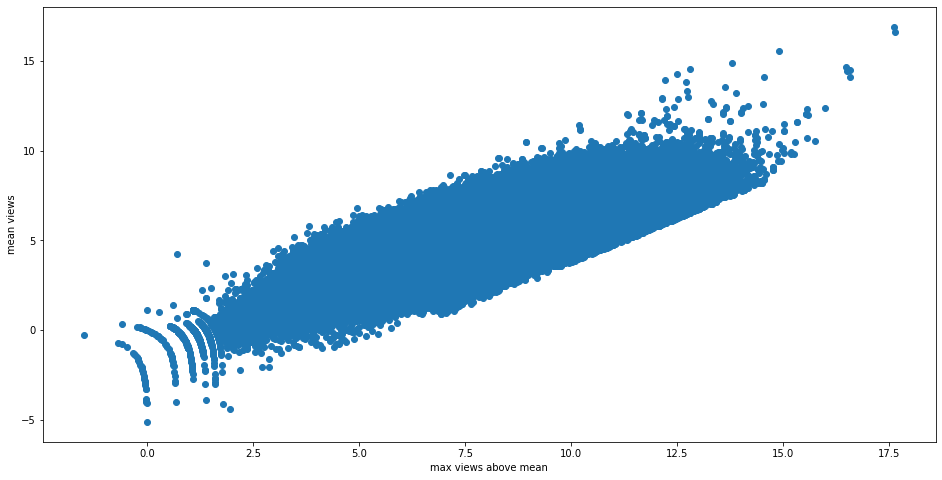

In [39]:
above_max=par_page['max_view']-par_page['mean_view']

plt.figure(figsize=(16, 8))
plt.scatter(np.log(above_max),par_page['log_mean_view'])
plt.xlabel("max views above mean")
plt.ylabel("mean views")
plt.show()

We find:

There is a clear correlation between mean views and maximum views. Also here we find again the two cluster peaks we had identified in the individual histograms. A couple of outliers and outlier groups are noticeable.

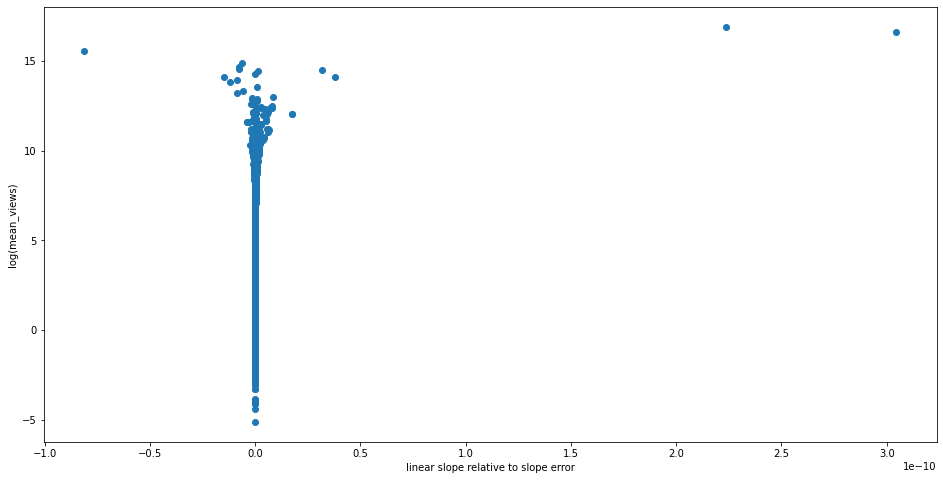

In [40]:
#Another question: Does the (assumed) linear change in views depend on the total number of views?
plt.figure(figsize=(16, 8))
plt.scatter(par_page['slope'],np.log(par_page['mean_view']))
plt.xlabel("linear slope relative to slope error")
plt.ylabel("log(mean_views)")
plt.show()

We find that articles with higher average view-count have more variability in their linear trends.However, this might be due to our slope normalisation which will decrease the effective slope for low view counts. It should not, however, affect the observation that the slopes of low-view articles are on average slightly higher than those of high-view articles. Such an effect could be caused by viewing spikes, of course, but I would expect those to be randomly distributed.

Note: 
Here slope= coeff/(standard Error) which is basically t statistics
If 95% of the t distribution is closer to the mean than the t-value on the coefficient you are looking at, then you have a P value of 5%. This is also reffered to a significance level of 5%. The P value is the probability of seeing a result as extreme as the one you are getting (a t value as large as yours) in a collection of random data in which the variable had no effect. A P of 5% or less is the generally accepted point at which to reject the null hypothesis. With a P value of 5% (or .05) there is only a 5% chance that results you are seeing would have come up in a random distribution, so you can say with a 95% probability of being correct that the variable is having some effect, assuming your model is specified correctly.

# Individual observations with extreme parameters

Based on the overview parameters we can focus our attention on those articles for which the time series parameters are at the extremes of the parameter space.

## Large linear slope

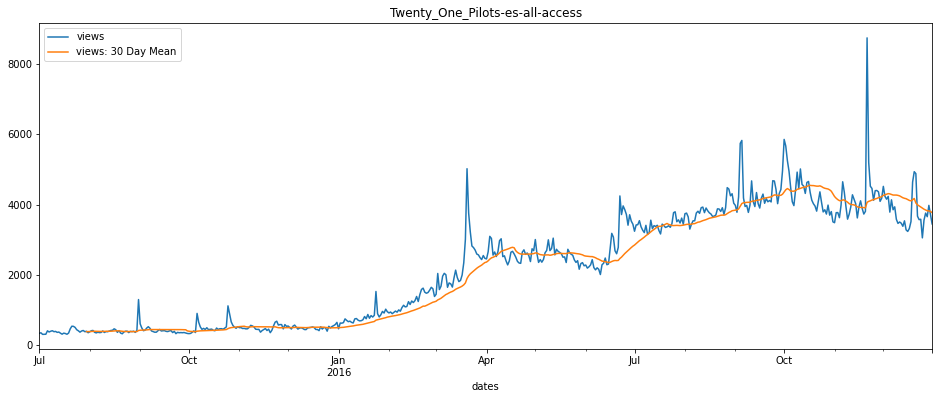

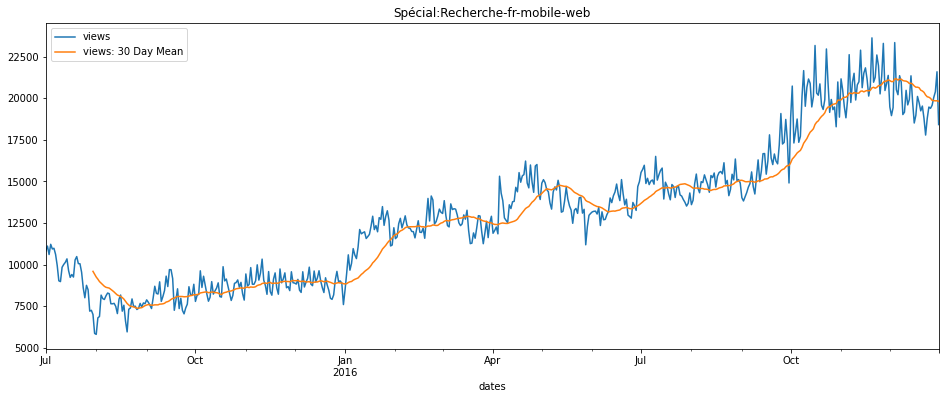

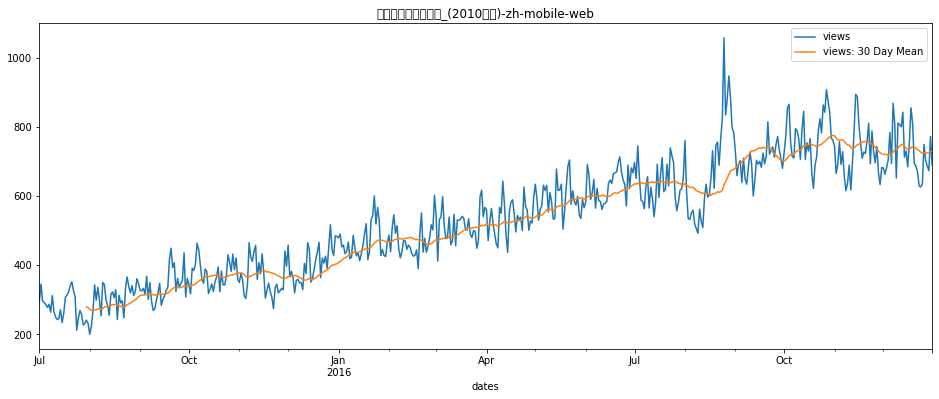

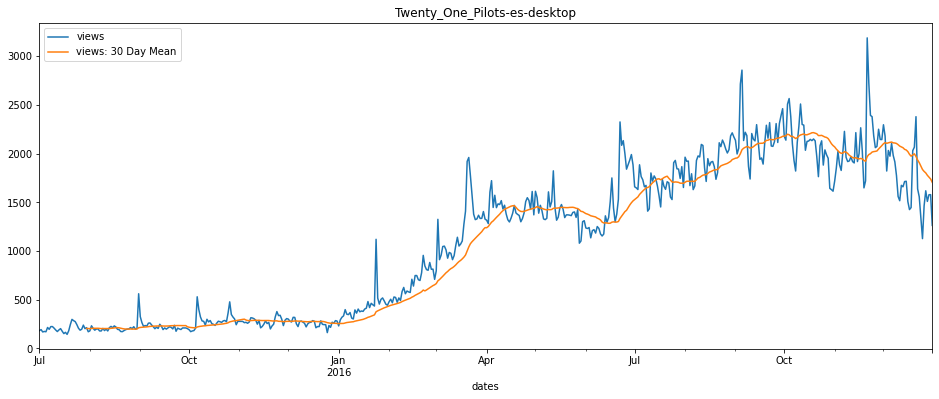

In [85]:
slope_sort=params1.sort_values(by=['slope'],ascending=False).head()
plot_rownr(91727)
plot_rownr(55586)
plot_rownr(108340)
plot_rownr(70771)

Lot’s of love for Twenty One Pilots in Spain. Those rapid rises and wibbly-wobbly bits are going to be difficult to predict, unless there’s a periodic modulation on top of the large-scale trend. Certaintly worth figuring out.

We also see that our smoother is dealing rather well with most of the slower variability patterns and could be used to remove the low-frequency structures for further analysis.

Let’s compare the interest in Twenty One Pilots for the different countries, to see whether a prediction for one of them could learn from the others:

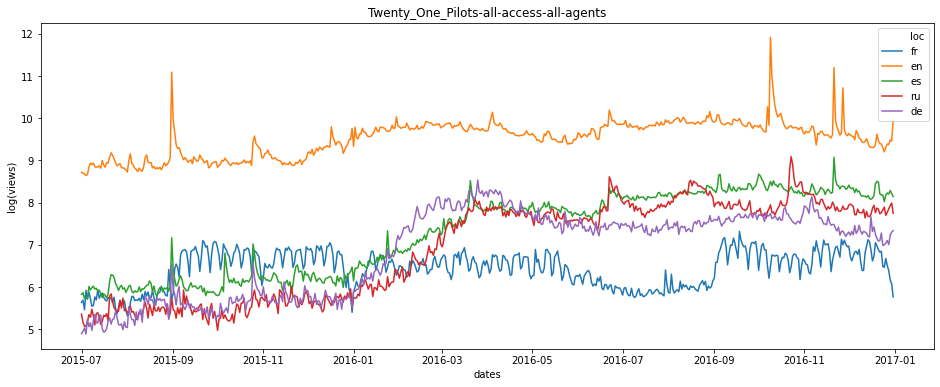

In [86]:
plot_names_nrm("Twenty_One_Pilots", "all-access", "all-agents")

Note, that those curves are normalised to mean views (each) and have a logarithmic y-axis to mitigate the effect of large spikes. This chart is for relative trend comparison.

We find:

Germany and France show quite similar viewing behaviour, while Russia and Spain are comparable too; especially in the early rise in interest. The English pages show less dramatic changes but end up

With a purely time-series-forecast approach I think that the large spikes are close to impossible to predict. However, external data could help a lot here.

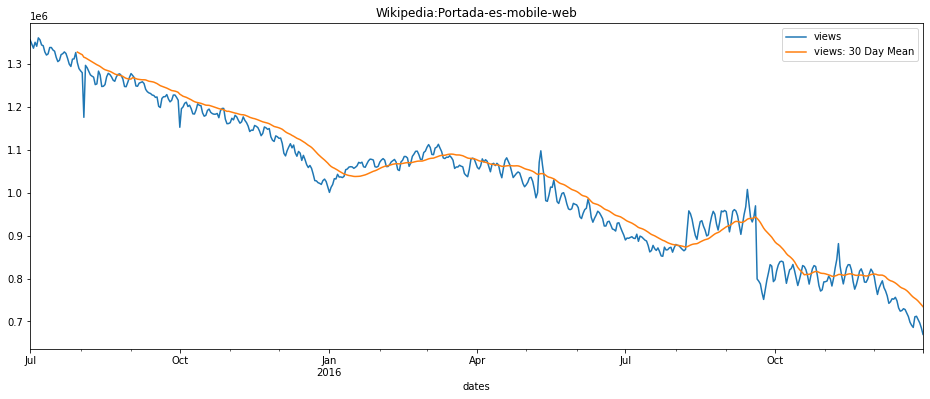

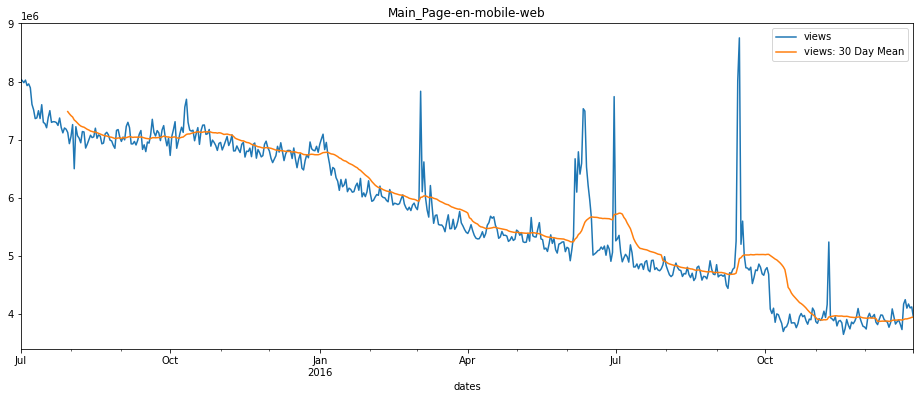

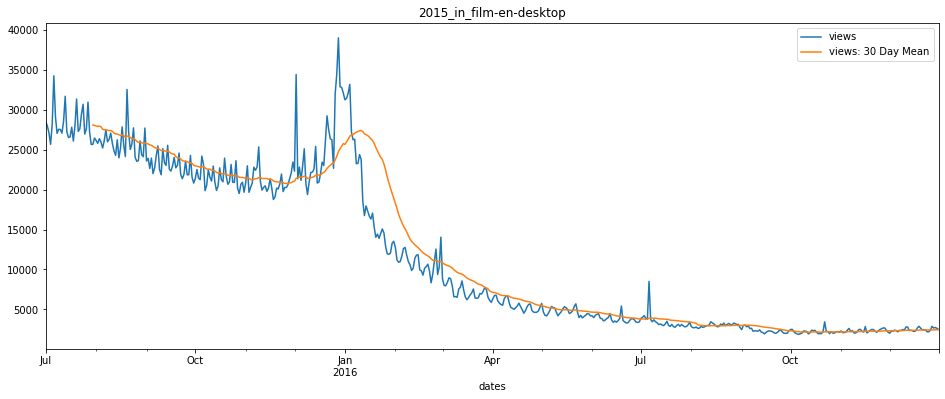

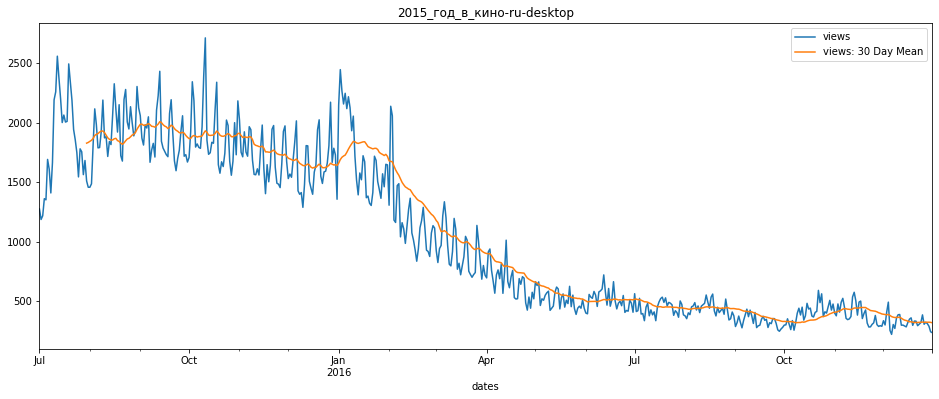

In [87]:
#Those viewing numbers were going up, but which articles were going down?
slope_sort=params1.sort_values(by=['slope'],ascending=False).tail()

plot_rownr(95855)
plot_rownr(74114)
plot_rownr(8387)
plot_rownr(103658)

The main page itself on mobile, and review articles on 2015 were the biggest losers.

# High standard deviations

In [45]:
params1.sort_values(by=['sd_view'],ascending=False).head()

rowname    min_view    max_view     mean_view    med_view  \
9732      9774   8091010.0  62288712.0  1.595363e+07  12733277.5   
32042    38573  13658940.0  67264258.0  2.193851e+07  19457533.0   
84899   103123    343105.0  17332270.0  1.350691e+06    702277.5   
81105    99322    865616.0  17846030.0  1.974581e+06   1352373.0   
63193    74114   3645577.0   8752306.0  5.734518e+06   5650391.0   

            sd_view         slope  
9732   9.529194e+06  3.044565e-10  
32042  9.071410e+06  2.235437e-10  
84899  2.879428e+06  3.799340e-11  
81105  2.856762e+06  3.171059e-11  
63193  1.190981e+06 -8.112268e-11

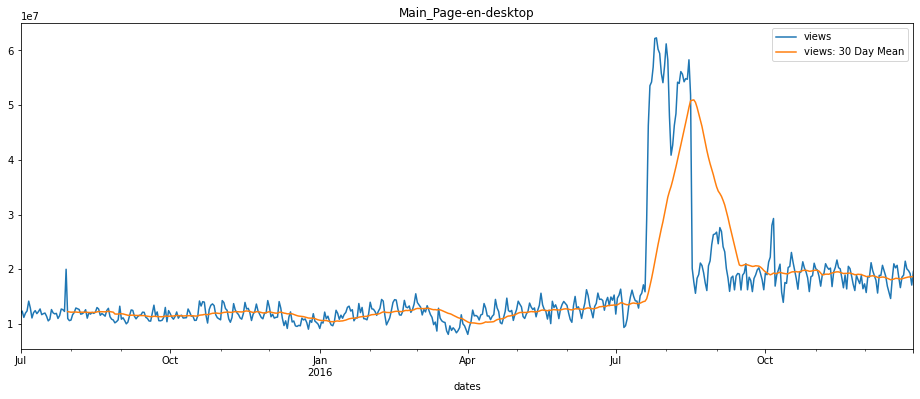

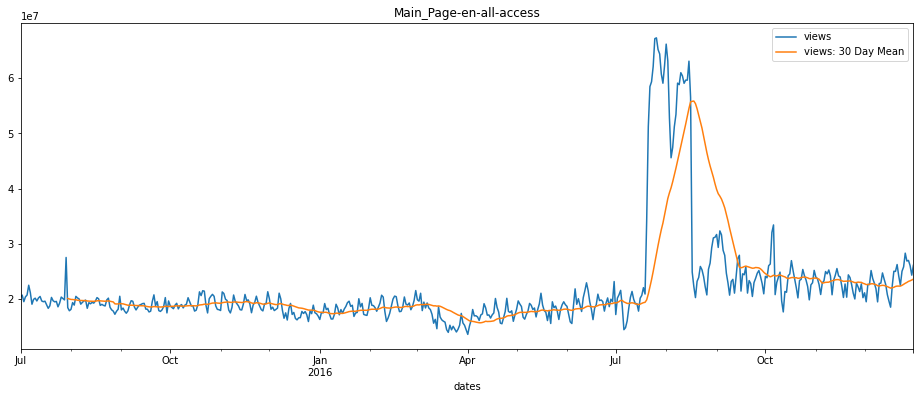

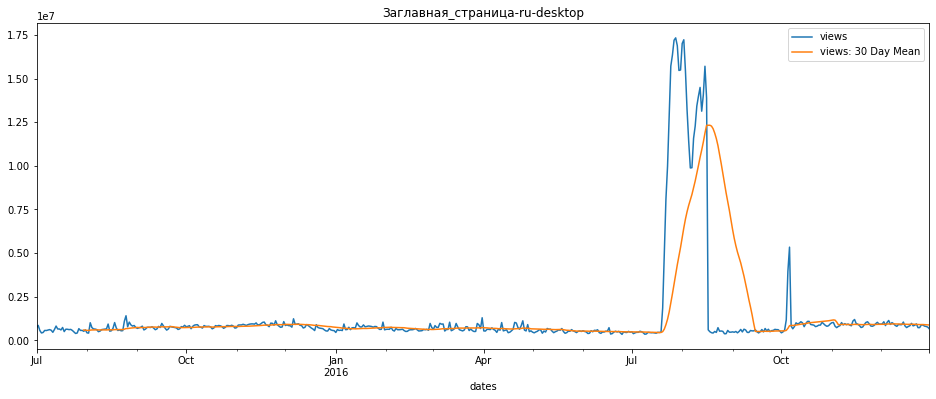

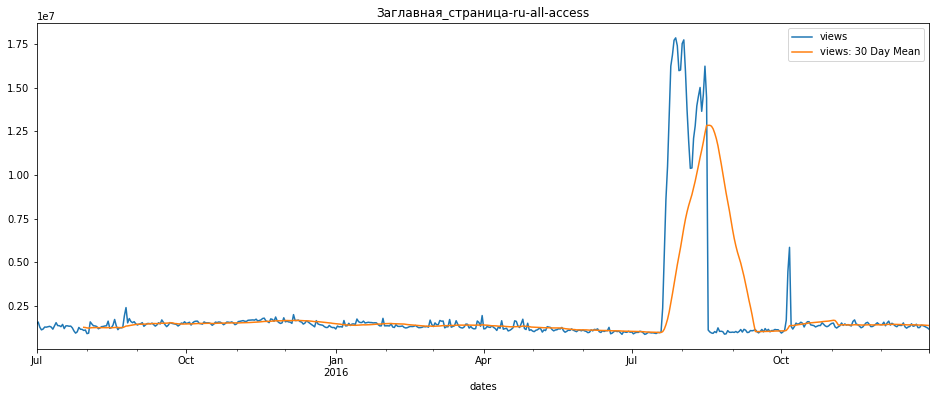

In [46]:
plot_rownr(9774)
plot_rownr(38573)
plot_rownr(103123)
plot_rownr(99322)

Those are pretty strong spikes in the main page views, even if the baseline is around 1-10 million to begin with. They look consistent though over different languages. Any ideas what could cause this?

If we normalise standard deviation by mean we get a different set of results:

In [47]:
params_sd=copy.deepcopy(params1)
params_sd['sd_view/mean_view']=params1['sd_view']/params1['mean_view']
sd_sort=params_sd.sort_values(by=['sd_view/mean_view'],ascending=False).head()
sd_sort

rowname  min_view   max_view    mean_view  med_view       sd_view  \
9989     10031       2.0  1980173.0  3612.683636      11.0  84434.332344   
32280    38811       4.0  1980179.0  3616.916364      15.0  84434.408075   
68768    86904       2.0   674556.0  1240.067273      12.0  28762.584471   
84296   102520       0.0   309442.0   571.154545       7.0  13194.288180   
7314      7351       7.0  1300713.0  2402.661818      34.0  55460.983286   

              slope  sd_view/mean_view  
9989   4.356805e-13          23.371637  
32280  4.357439e-13          23.344308  
68768  2.710523e-14          23.194374  
84296  6.347113e-14          23.101082  
7314   6.813404e-14          23.083142

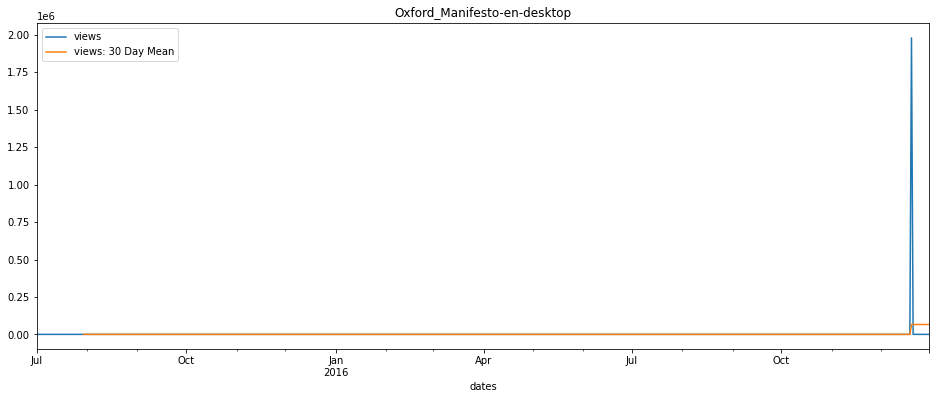

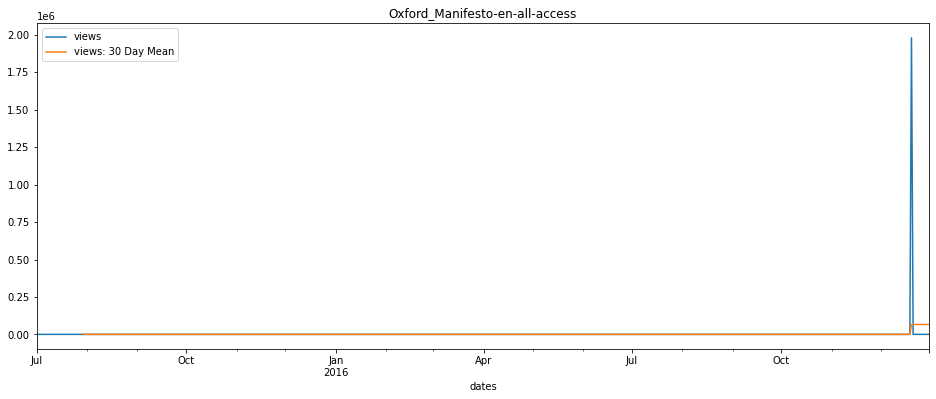

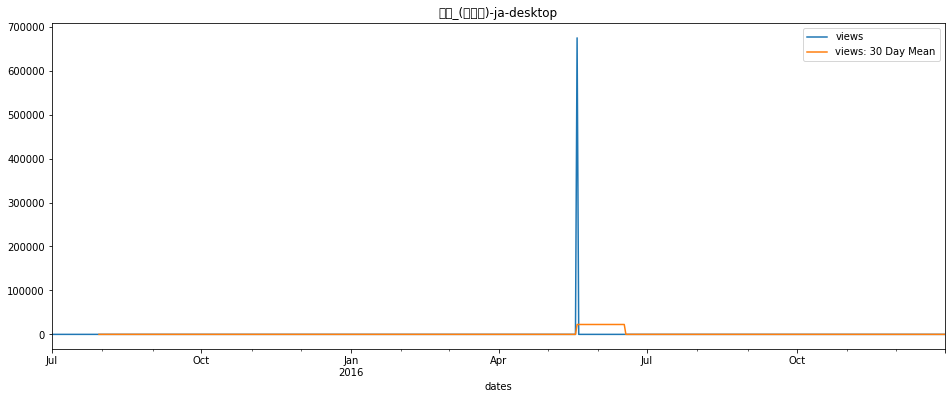

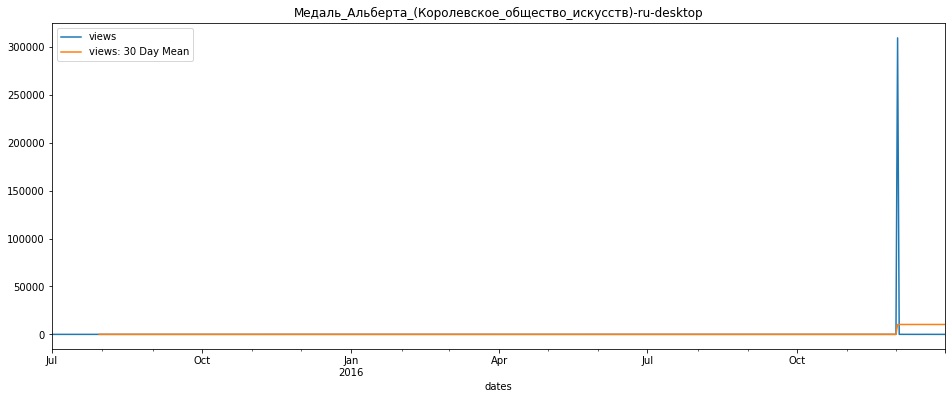

In [48]:
plot_rownr(10031)
plot_rownr(38811)
plot_rownr(86904)
plot_rownr(102520)

Those are very, very suspicious. They are essentially low baselines with single dates that have way higher view counts These have to be errors in the data which can be dangerous for predictions if they appear close to either end of the date window. In other cases, most smoothing methods should be able to deal with them.

# Large variability amplitudes

The top amplitudes are the same as the top standard deviations, due to the spikey nature of the variability:

In [49]:
params_sd['amplitude']=params1['max_view']-params1['mean_view']
sd_sort=params_sd.sort_values(by=['amplitude'],ascending=False).head()
sd_sort

rowname    min_view    max_view     mean_view    med_view  \
9732      9774   8091010.0  62288712.0  1.595363e+07  12733277.5   
32042    38573  13658940.0  67264258.0  2.193851e+07  19457533.0   
84899   103123    343105.0  17332270.0  1.350691e+06    702277.5   
81105    99322    865616.0  17846030.0  1.974581e+06   1352373.0   
10360    10403   1030746.0  16592075.0  1.839723e+06   1710496.5   

            sd_view         slope  sd_view/mean_view     amplitude  
9732   9.529194e+06  3.044565e-10           0.597306  4.633508e+07  
32042  9.071410e+06  2.235437e-10           0.413493  4.532575e+07  
84899  2.879428e+06  3.799340e-11           2.131819  1.598158e+07  
81105  2.856762e+06  3.171059e-11           1.446769  1.587145e+07  
10360  9.548806e+05  1.156875e-12           0.519035  1.475235e+07

# High average views

Those are the time series of the most popular pages, which we already identified as the main pages in the plots above:

In [50]:
params_sd.sort_values(by=['mean_view'],ascending=False).head()

rowname    min_view    max_view     mean_view    med_view  \
32042     38573  13658940.0  67264258.0  2.193851e+07  19457533.0   
9732       9774   8091010.0  62288712.0  1.595363e+07  12733277.5   
63193     74114   3645577.0   8752306.0  5.734518e+06   5650391.0   
120732   139119   2299516.0   3907598.0  2.916244e+06   2900707.0   
32649     39180   1421005.0  16991932.0  2.371053e+06   2150712.0   

             sd_view         slope  sd_view/mean_view     amplitude  
32042   9.071410e+06  2.235437e-10           0.413493  4.532575e+07  
9732    9.529194e+06  3.044565e-10           0.597306  4.633508e+07  
63193   1.190981e+06 -8.112268e-11           0.207686  3.017788e+06  
120732  2.569103e+05 -6.434754e-12           0.088096  9.913539e+05  
32649   1.026681e+06 -7.662260e-12           0.433006  1.462088e+07

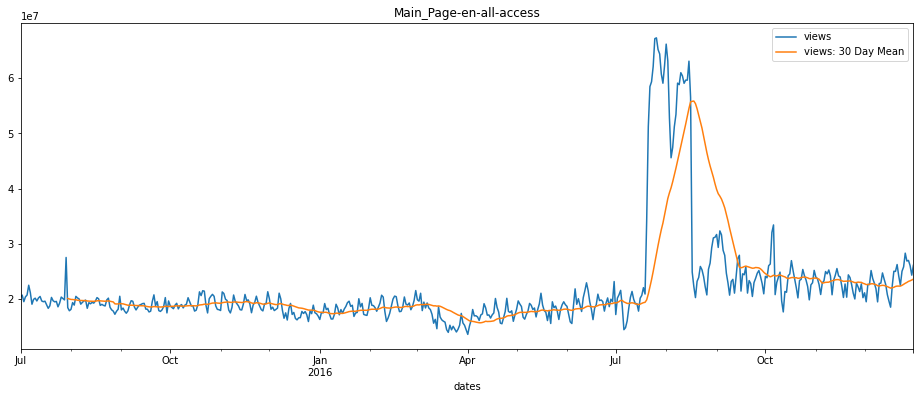

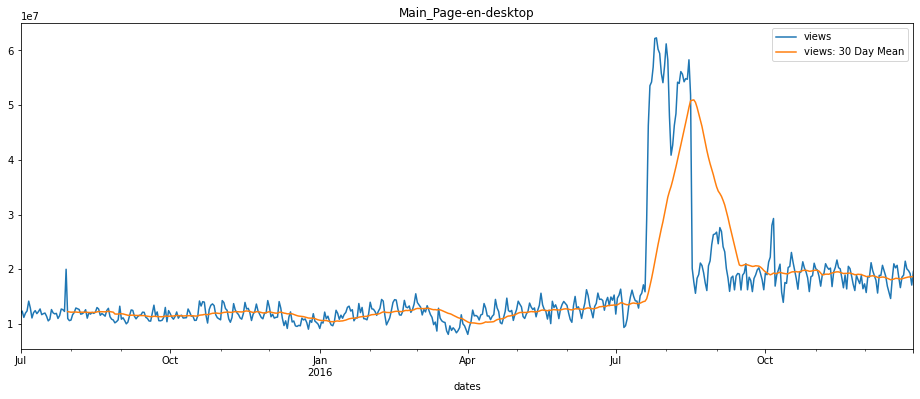

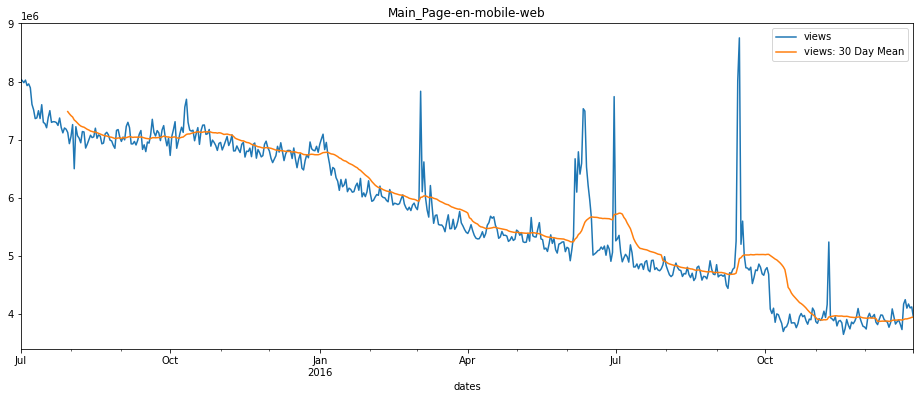

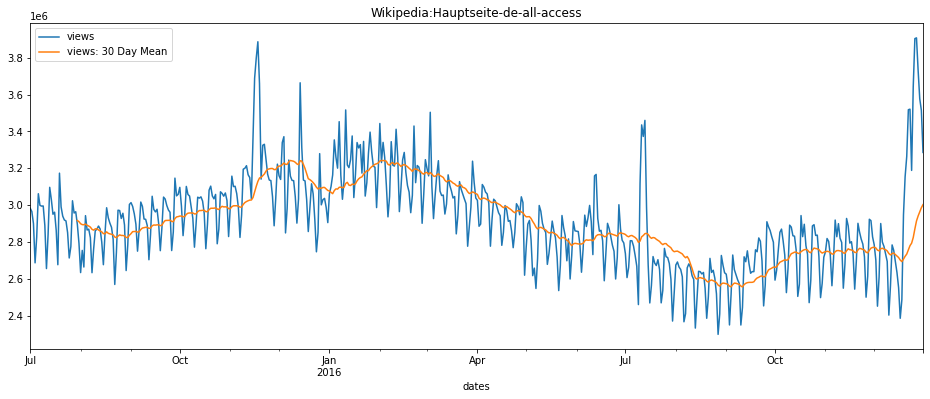

In [51]:
plot_rownr(38573)
plot_rownr(9774)
plot_rownr(74114)
plot_rownr(139119)

In addition to the spikes on the english main page there is a suprising amount of variability as exemplified by the long-term structure in the German main page.

##### In summary: We have identified the time series’ with the highest variability according to basic criteria. We also found a few time series sets with bogus values. These are the data sets that might pose the greatest challenge to our prediction algorithms.

# Short-term variability

Before turning to forecasting methods, let’s have a closer look at the characteristic short-term variability that has become evident in several of the plots already. Below, we plot a 2-months zoom into the “quiet” parts (i.e. no strong spikes) of different time series:

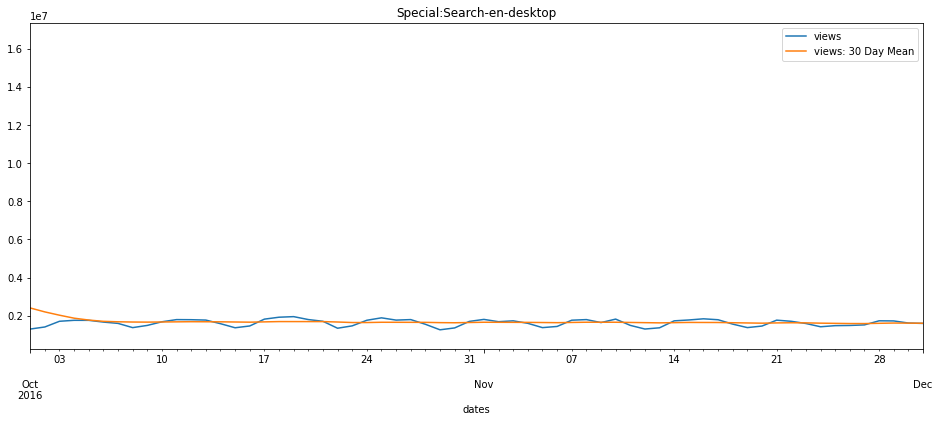

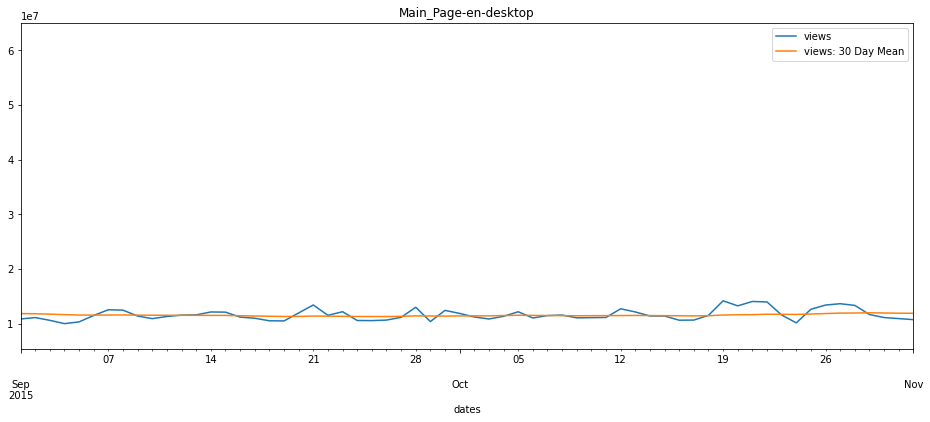

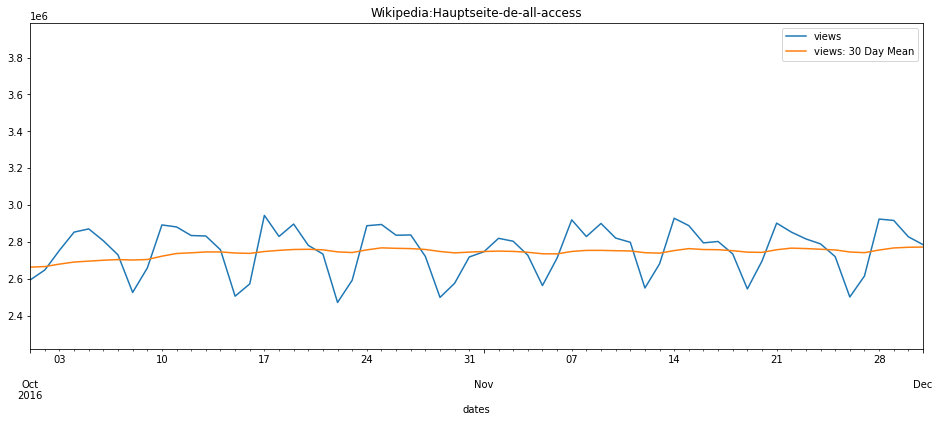

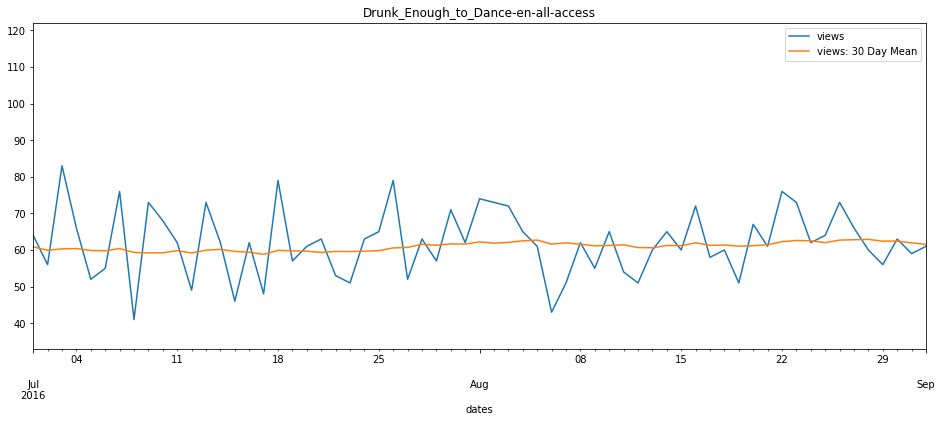

In [53]:
#10403- High Amplitude
#9774- High Average View & High Variability Amplitude & High Standard Deviation
#139119- High Average View

plot_rownr_zoom(10403, "2016-10-01", "2016-12-01")
plot_rownr_zoom(9774, "2015-09-01", "2015-11-01")
plot_rownr_zoom(139119, "2016-10-01", "2016-12-01")
plot_rownr_zoom(110657, "2016-07-01", "2016-09-01")

We see that the high-view-count time series on the 1st and 3rd plot that show a very regular periodicity that is strikingly similar for both of them. A similar structure can be seen on the 2nd and 4th plot, although here it is partly distorted by a slight upward trend (2nd plot) and/or variance caused by lower viewing numbers (4th plot).

These plots provide evidence that there is variability on a weekly scale. The next figure will visualise this weekly behaviour in a different way:

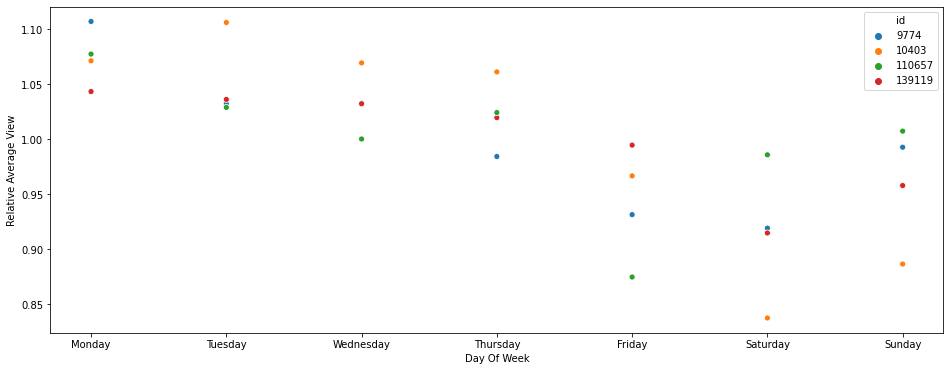

In [54]:
# get days- enter the dataframe- there should be a column 'dates
def weekdayName_views(dataframe):
    for i in dataframe.index:
        d=dataframe.loc[i,['dates']][0]
        week_num = d.weekday()
        weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
        week_num_asName = weekDays[week_num]
        dataframe.loc[i,['dates']]=week_num_asName
    return dataframe

foo11=extract_ts(10404)
weekdayName_views(foo11)

def weekDay_views(rownr,startDate,endDate):
    foo1=extract_ts(rownr)
    foo1=foo1[(foo1['dates']>startDate)&(foo1['dates']<endDate)]
    weekdayName_views(foo1)
    foo2=foo1.groupby(['dates']).mean()
    foo2['wday_views']=foo2['views']/np.mean(foo2['views'])
    foo2['id']=rownr
    foo2.drop(['views'],axis=1,inplace=True)
    foo2.reset_index(inplace=True)
    foo2['dates']=foo2['dates'].astype('category')
    foo2['dates']=foo2['dates'].cat.reorder_categories(["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"], ordered=True)
    foo2=foo2.sort_values(by=['dates'])
    foo2.reset_index(drop=True,inplace=True)    
    return foo2

foo1=weekDay_views(10403,"2016-10-01","2016-12-01")
foo2=weekDay_views(9774, "2015-09-01","2015-11-01")
foo3=weekDay_views(139119, "2016-10-01","2016-12-01")
foo4=weekDay_views(110657,"2016-07-01","2016-09-01")

foo_all=[foo1,foo2,foo3,foo4]
foo=pd.concat(foo_all)
foo.reset_index(drop=True,inplace=True)
foo['id']=foo['id'].astype('category')

plt.figure(figsize=(16, 6))
ax=sns.scatterplot(x="dates", y="wday_views", hue="id",data=foo)
ax.set(xlabel='Day Of Week',ylabel='Relative Average View');

Here we average the variability in the previous plot over the day of the week and then overlay all four time series with different colours on a relative scale. We see the clear trend toward lower viewing numbers on the weekend (Fri/Sat/Sun), and also a declining trend as we approach the weekend. This gives us valuable information on the general type of variability over the course of a week. In order to study this behaviour more in detail, we would need to average over a larger number of time series.

##### In our following analysis we can therefore reasonably assume that a period of 7 days is present in all our articles.

# Forecast methods for selected examples

Now that we have identified a sample of time series’ with extreme parameters we can use them to test different forecasting methods.Therefore, our forecasting method will have to perform robustly for a range of different time series shapes and varibilities. Those methods that manage to deal with our extreme examples should be able to deal with any less variable time series as well.

For this project our forecast period is 2 monts, i.e. about 60 days. In the following, we simulate this period and assess our prediction accuracy by keeping a hold-out sample of the last 60 days from our forecasting data. After making the prediction we can compare the actual view counts to the forecasted ones.

We have considered following extreme cases:
1. Large/Highest Linear Slope (Articles whose views are going up) - [rowname = 70772, 108341]
2. Small/Least Linear Slope (Articles whose views are going down) - [rowname = 95856]
3. High Standard Deviation (Articles whose views have high fluctuations) - [Views of these are not possible to predict without any external dataset]
4. Large Variability in Amplitude (Same as High Standard Deviation, so difficult to predict)
5. High Average Views (Articles which are viewed in large amount) - [rowname = 139120]

## ARIMA(p,d,q)
<strong>ARIMA</strong>, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes <strong>SARIMA</strong>, short for <strong>‘Seasonal ARIMA’</strong>. More on that once we finish ARIMA.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMA.html'>arima_model.ARMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Moving Average ARMA(p,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.html'>arima_model.ARMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;Class to hold results from fitting an ARMA model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html'>arima_model.ARIMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Integrated Moving Average ARIMA(p,d,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.html'>arima_model.ARIMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;Class to hold results from fitting an ARIMA model<br>	
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.kalmanf.kalmanfilter.KalmanFilter.html'>kalmanf.kalmanfilter.KalmanFilter</a></strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Kalman Filter code intended for use with the ARMA model</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model'>Wikipedia</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive–moving-average model</font><br>
<strong>
<a href='https://otexts.com/fpp2/non-seasonal-arima.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Non-seasonal ARIMA models</font></div>

## SARIMA(p,d,q)(P,D,Q)m
## Seasonal Autoregressive Integrated Moving Averages
We have finally reached one of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables. We'll cover these in the next section.


<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font></div>

In [55]:
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Data Preparation
For this project our forecast period is 2 monts, i.e. about 60 days. In the following, we simulate this period and assess our prediction accuracy by keeping a hold-out sample of the last 60 days from our forecasting data. After making the prediction we can compare the actual view counts to the forecasted ones.

##### Predict for rowname = 70771 ( article going up - large linear slope ) - ARIMA

There is no missing data


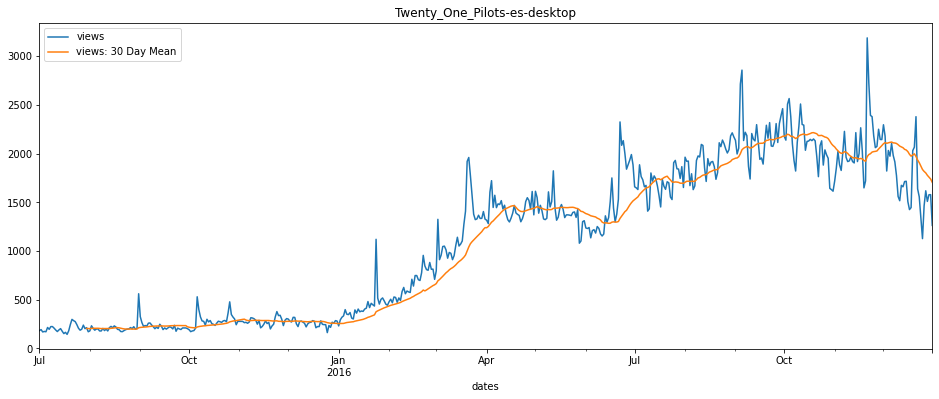

In [213]:
rown=70771
pageviews=extract_ts(rown)
pageviews.set_index('dates',inplace=True)
pageviews.index.freq = 'D'
pageviews['rowname']=rown

if (pageviews['views'].isnull().sum()==0):
    print('There is no missing data')
else:
    print('There are {m} missing data'.format(m=pageviews['views'].isnull().sum()))

pred_len = 60
pred_range = [pageviews.shape[0]-pred_len+1, pageviews.shape[0]]
pre_views = pageviews.head(pageviews.shape[0]-pred_len)
post_views = pageviews.tail(pred_len)

plot_rownr(70771)

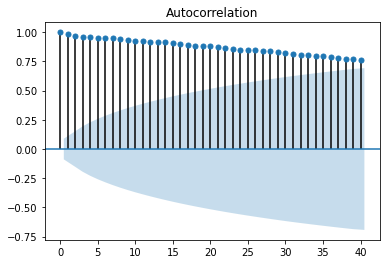

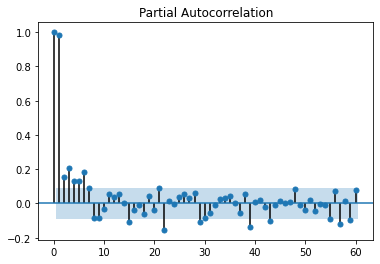

In [214]:
# Now let's plot the acf and pacf at different lags
title = 'Autocorrelation'
lags = 40
plot_acf(pre_views['views'],title=title,lags=lags);

title='Partial Autocorrelation'
lags=60
plot_pacf(pre_views['views'],title=title,lags=lags);

### Tests for unit roots
When investigating any relationship between two time series variables we should check whether time series models that contain unit roots are suitable. If they are, we need to decide whether or not there is a common stochastic trend. The first step is to see how well each series can be approximated as a random walk by looking at the correlogram of the differenced series. 

Whilst this may work for a simple random walk, for example stochastic trends are a feature of any time series model with a unit root B = 1 as a solution of the characteristic equation, which would include more complex ARIMA processes.

Dickey and Fuller developed a test of the null hypothesis that α = 1 against an alternative hypothesis that α < 1 for the model 'xt = αxt−1 + ut' in which 'ut' is white noise. A more general test, which is known as the augmented <strong>Dickey-Fuller test</strong> (Said and Dickey, 1984), allows the differenced series ut to be any stationary process, rather than white noise, and approximates the stationary process with an AR model.


In [215]:
adf_p_value=statsmodels.tsa.stattools.adfuller(pageviews['views'])

if (adf_p_value[1]>0.05):
    print('p-value is {p} which is more than 0.05. So this time series is non-stationary'.format(p=adf_p_value[1]))
else:
    print('p-value is {p} which is less than 0.05. So this time series is stationary'.format(p=adf_p_value[1]))

p-value is 0.6613367761942982 which is more than 0.05. So this time series is non-stationary


In [59]:
auto_arima(pre_views['views'], start_p=0, start_q=0,test='adf',
                           max_p=2, max_q=2, m=7,
                           start_P=0,start_Q=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  490
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -2992.595
Date:                           Mon, 06 Jul 2020   AIC                           5995.189
Time:                                   05:20:30   BIC                           6016.079
Sample:                                        0   HQIC                          6003.399
                                           - 490                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0311      0.120     -0.260      0.795      -0.266       0.203
ar.L1          0.4919      0.068      7.202      0.000       0.358       0.626
ma.L1         -0.8135      0.051    -15.892      0.000      -0.914      -0.713
ma.S.L7       -0.9072      0.020    -46.349      0.000      -0.946      -0.869
sigma2      1.409e+04    409.450     34.408      0.000    1.33e+04    1.49e+04
===================================================================================
Ljung-Box (Q):                       28.91   Jarque-Bera (JB):              2737.58
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              10.27   Skew:                             1.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [220]:
def SARIMAX_fit(p,d,q,P,D,Q,S):
    model = SARIMAX(pre_views['views'],order=(p,d,q),seasonal_order=(P,D,Q,S))
    results = model.fit()
    print(results.summary())
    
    # Obtain predicted values
    start=len(pre_views)
    end=len(pre_views)+len(post_views)-1
    rename=('SARIMA({p},{d},{q})({P},{D},{Q},{S}) Predictions'.format(p=p,d=d,q=q,P=P,D=D,Q=Q,S=S))
    predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(rename)
    
    # Plot predictions against known values
    title = rename
    ylabel='Views'
    xlabel=''
    
    ax = pageviews['views'].plot(legend=True,figsize=(16,6),title=title)
    predictions.plot(legend=True)
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel);
    plt.show()
    
    # plot residual
    title = 'Residual Plot'
    residual=post_views['views']-predictions
    
    # RMSE
    RMSE=np.sqrt(np.mean(np.array(residual)*np.transpose(np.array(residual))))
    print('RMSE = {r}'.format(r=RMSE))
    
    # MAPE
    MAPE=np.mean(np.absolute(np.array(residual))/post_views['views']*100)
    print('MAPE = {m}'.format(m=MAPE))
    
    residual.plot(figsize=(16,6),title=title)
    plt.show()
    
    # Now let's plot the acf and pacf at different lags
    title = 'Autocorrelation Plot for Residual'
    lags = 40
    plot_acf(residual,title=title,lags=lags);
    
    title='Partial Autocorrelation Plot for Residual'
    lags=40
    plot_pacf(residual,title=title,lags=lags);
     
    return [predictions,residual]

                                     SARIMAX Results                                     
Dep. Variable:                             views   No. Observations:                  490
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -2992.633
Date:                           Tue, 07 Jul 2020   AIC                           5993.266
Time:                                   01:34:19   BIC                           6009.978
Sample:                               07-01-2015   HQIC                          5999.834
                                    - 11-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4922      0.068      7.273      0.000       0.360       0.625
ma.L1         -0.8136      0.051    -15.978

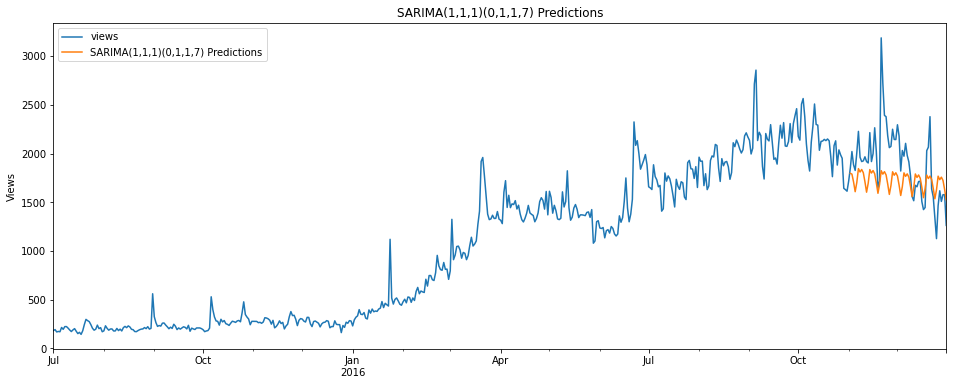

RMSE = 360.9880146841436
MAPE = 13.871873287384853


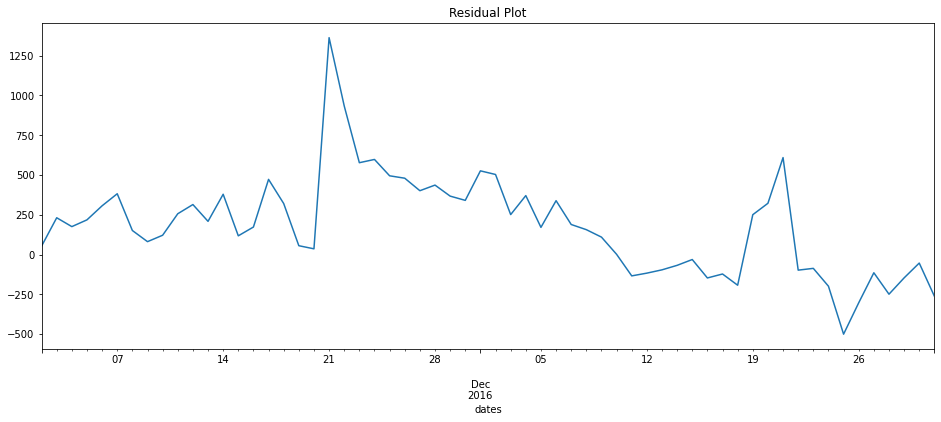

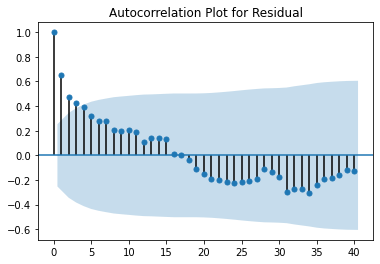

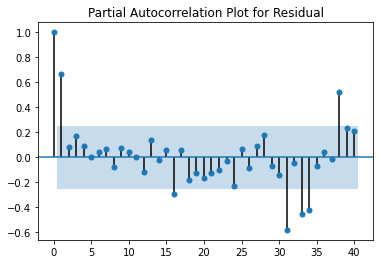

In [221]:
pred_resid=SARIMAX_fit(1,1,1,0,1,1,7)

ADF test for Residual (obtained for above model)

In [62]:
adf_p_value=statsmodels.tsa.stattools.adfuller(pred_resid[1])

if (adf_p_value[1]>0.05):
    print('p-value is {p} which is more than 0.05. So this time series is non-stationary'.format(p=adf_p_value[1]))
else:
    print('p-value is {p} which is less than 0.05. So this time series is stationary'.format(p=adf_p_value[1]))


p-value is 0.018780159978175573 which is less than 0.05. So this time series is stationary


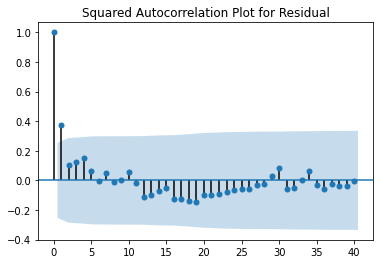

In [63]:
sq_resid=(np.array(pred_resid[1]))*(np.array(pred_resid[1]))

title = 'Squared Autocorrelation Plot for Residual'
lags = 40
plot_acf(sq_resid,title=title,lags=lags);   

The results are not too bad, actually. But this seems challenging problem, because the levelling of the viewer numbers at the end of the time range was not predictable from the previous behaviour.

I also plotted <strong>Squared Autocorrelation Plot for Residual</strong> which shows there is no case for <strong>conditional heteroskedastic</strong>, so we don't need to use <strong>GARCH Model</strong>

But we can do better as we go on implementing different models and check the performance.

##### Predict for rowname = 108340 ( article going up - large linear slope ) - ARIMA

In [222]:
rown=108340
pageviews=extract_ts(rown)
pageviews.set_index('dates',inplace=True)
pageviews.index.freq = 'D'
pageviews['rowname']=rown

if (pageviews['views'].isnull().sum()==0):
    print('There is no missing data')
else:
    print('There are {m} missing data'.format(m=pageviews['views'].isnull().sum()))

pred_len = 60
pred_range = [pageviews.shape[0]-pred_len+1, pageviews.shape[0]]
pre_views = pageviews.head(pageviews.shape[0]-pred_len)
post_views = pageviews.tail(pred_len)


#plot_rownr(108340)

There is no missing data


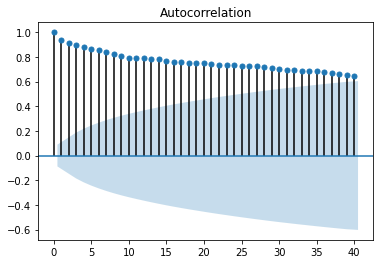

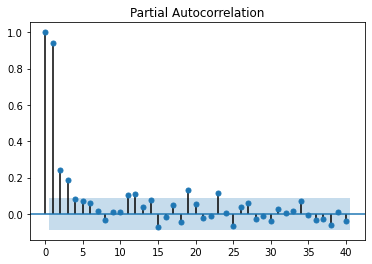

In [223]:
# Now let's plot the acf and pacf at different lags
title = 'Autocorrelation'
lags = 40
plot_acf(pre_views['views'],title=title,lags=lags);

title='Partial Autocorrelation'
lags=40
plot_pacf(pre_views['views'],title=title,lags=lags);

In [66]:
auto_arima(pre_views['views'], start_p=0, start_q=0,test='adf',
                           max_p=2, max_q=2, m=7,
                           start_P=0,start_Q=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  490
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -2573.029
Date:                           Mon, 06 Jul 2020   AIC                           5154.058
Time:                                   05:21:31   BIC                           5170.770
Sample:                                        0   HQIC                          5160.626
                                           - 490                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0115      0.053      0.215      0.830      -0.093       0.116
ma.L1         -0.4702      0.035    -13.432      0.000      -0.539      -0.402
ma.S.L7       -0.9994      1.002     -0.998      0.318      -2.963       0.964
sigma2      2385.3324   2334.318      1.022      0.307   -2189.846    6960.511
===================================================================================
Ljung-Box (Q):                       57.27   Jarque-Bera (JB):                50.80
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                                     SARIMAX Results                                     
Dep. Variable:                             views   No. Observations:                  490
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -2573.056
Date:                           Tue, 07 Jul 2020   AIC                           5152.113
Time:                                   01:37:41   BIC                           5164.646
Sample:                               07-01-2015   HQIC                          5157.038
                                    - 11-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4699      0.034    -13.636      0.000      -0.537      -0.402
ma.S.L7       -0.9973      0.225     -4.426

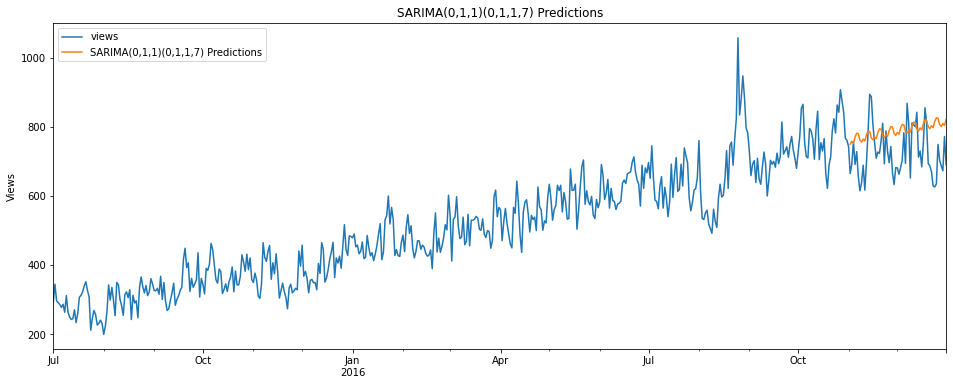

RMSE = 94.11691024435852
MAPE = 11.74985115596561


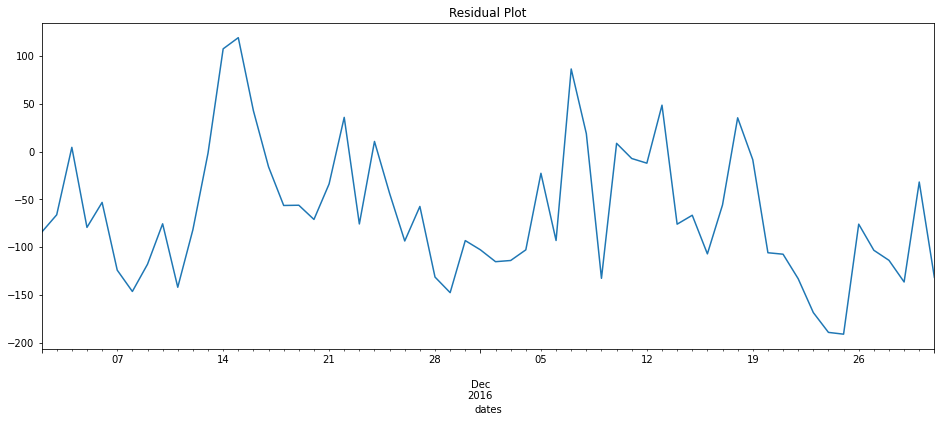

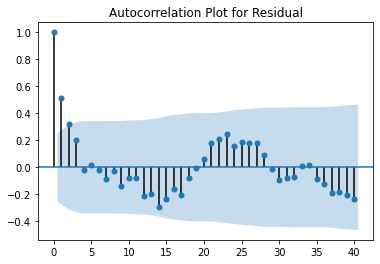

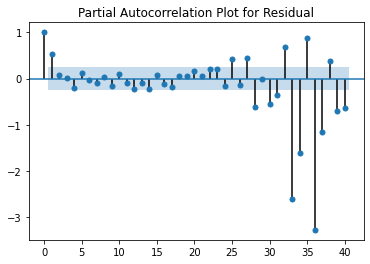

In [224]:
pred_resid=SARIMAX_fit(0,1,1,0,1,1,7)

In [68]:
adf_p_value=statsmodels.tsa.stattools.adfuller(pred_resid[1])

if (adf_p_value[1]>0.05):
    print('p-value is {p} which is more than 0.05. So this time series is non-stationary'.format(p=adf_p_value[1]))
else:
    print('p-value is {p} which is less than 0.05. So this time series is stationary'.format(p=adf_p_value[1]))


p-value is 0.0006979908100951512 which is less than 0.05. So this time series is stationary


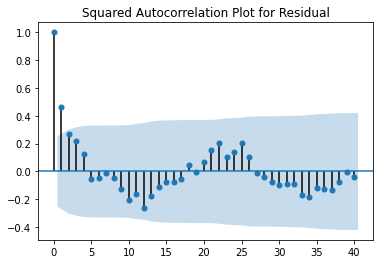

In [69]:
sq_resid=(np.array(pred_resid[1]))*(np.array(pred_resid[1]))

title = 'Squared Autocorrelation Plot for Residual'
lags = 40
plot_acf(sq_resid,title=title,lags=lags);   

<strong>Squared Autocorrelation Plot for Residual</strong> shows there is no case for <strong>conditional heteroskedastic</strong>, so we don't need to use <strong>GARCH Model</strong>

##### Predict for rowname = 95855 ( article going down - least linear slope ) - ARIMA

In [225]:
rown=95855
pageviews=extract_ts(rown)
pageviews.set_index('dates',inplace=True)
pageviews.index.freq = 'D'
pageviews['rowname']=rown

if (pageviews['views'].isnull().sum()==0):
    print('There is no missing data')
else:
    print('There are {m} missing data'.format(m=pageviews['views'].isnull().sum()))

pred_len = 60
pred_range = [pageviews.shape[0]-pred_len+1, pageviews.shape[0]]
pre_views = pageviews.head(pageviews.shape[0]-pred_len)
post_views = pageviews.tail(pred_len)


#plot_rownr(95855)

There is no missing data


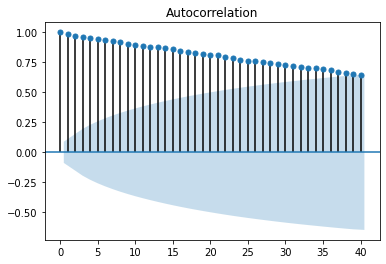

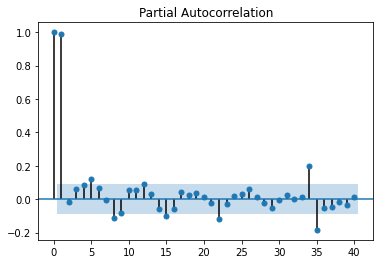

In [226]:
# Now let's plot the acf and pacf at different lags
title = 'Autocorrelation'
lags = 40
plot_acf(pre_views['views'],title=title,lags=lags);

title='Partial Autocorrelation'
lags=40
plot_pacf(pre_views['views'],title=title,lags=lags);

In [72]:
auto_arima(pre_views['views'], start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=7,
                           start_P=0,start_Q=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  490
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -5430.481
Date:                             Mon, 06 Jul 2020   AIC                          10868.962
Time:                                     05:22:02   BIC                          10885.674
Sample:                                          0   HQIC                         10875.530
                                             - 490                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -54.3045     65.573     -0.828      0.408    -182.825      74.216
ar.S.L7        0.7178      0.020     35.476      0.000       0.678       0.757
ma.S.L7       -0.9579      0.025    -38.297      0.000      -1.007      -0.909
sigma2       4.11e+08      0.000   1.89e+12      0.000    4.11e+08    4.11e+08
===================================================================================
Ljung-Box (Q):                      104.13   Jarque-Bera (JB):             23053.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -1.07
Prob(H) (two-sided):                  0.76   Kurtosis:                        36.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.9e+26. Standard errors may be unstable.
"""

                                      SARIMAX Results                                      
Dep. Variable:                               views   No. Observations:                  490
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -5434.434
Date:                             Tue, 07 Jul 2020   AIC                          10874.868
Time:                                     01:38:19   BIC                          10887.402
Sample:                                 07-01-2015   HQIC                         10879.794
                                      - 11-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.7296      0.013     55.338      0.000       0.704       0.755
ma.S.L7       -0.9723      

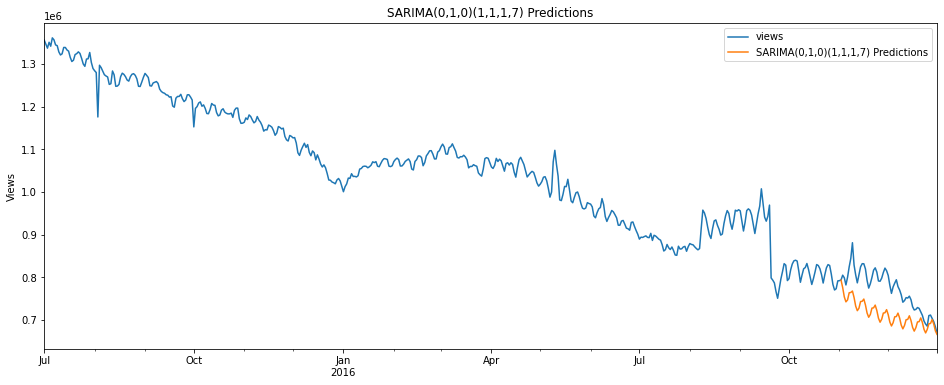

RMSE = 66095.18515564983
MAPE = 7.458505526315471


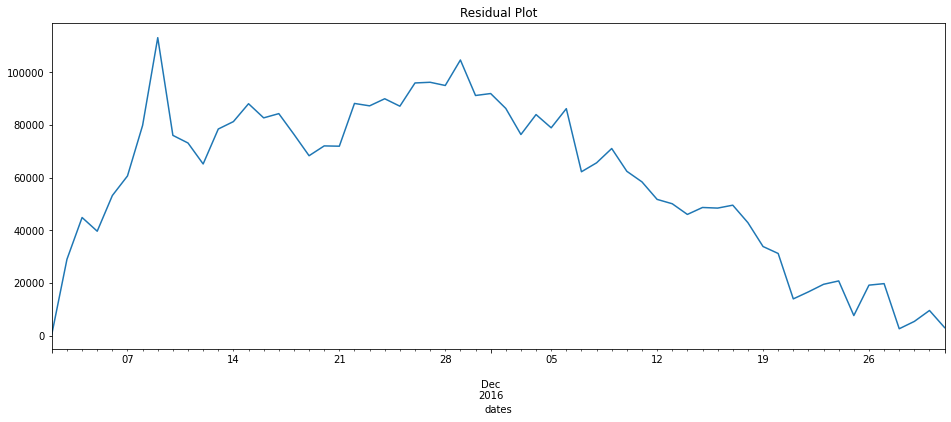

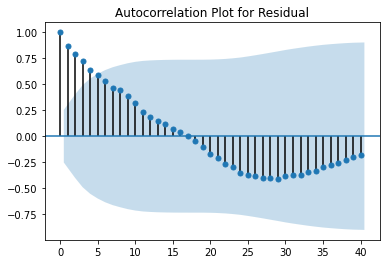

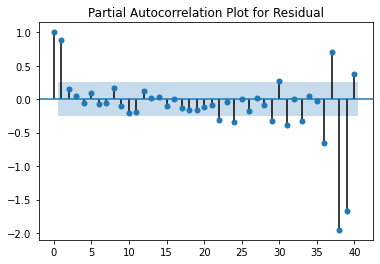

In [227]:
pred_resid=SARIMAX_fit(0,1,0,1,1,1,7)

In [74]:
adf_p_value=statsmodels.tsa.stattools.adfuller(pred_resid[1])

if (adf_p_value[1]>0.05):
    print('p-value is {p} which is more than 0.05. So this time series is non-stationary'.format(p=adf_p_value[1]))
else:
    print('p-value is {p} which is less than 0.05. So this time series is stationary'.format(p=adf_p_value[1]))

p-value is 0.8170070482273448 which is more than 0.05. So this time series is non-stationary


We see that residual is not stationary, so ARIMA did not fit well

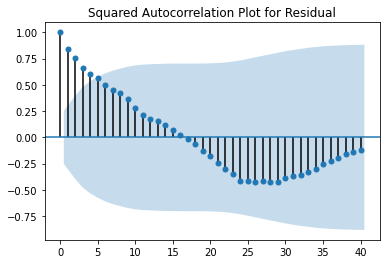

In [75]:
sq_resid=(np.array(pred_resid[1]))*(np.array(pred_resid[1]))

title = 'Squared Autocorrelation Plot for Residual'
lags = 40
plot_acf(sq_resid,title=title,lags=lags);   

##### Predict for rowname = 139119 ( article with average views ) - ARIMA

In [228]:
rown=139119
pageviews=extract_ts(rown)
pageviews.set_index('dates',inplace=True)
pageviews.index.freq = 'D'
pageviews['rowname']=rown

if (pageviews['views'].isnull().sum()==0):
    print('There is no missing data')
else:
    print('There are {m} missing data'.format(m=pageviews['views'].isnull().sum()))

pred_len = 60
pred_range = [pageviews.shape[0]-pred_len+1, pageviews.shape[0]]
pre_views = pageviews.head(pageviews.shape[0]-pred_len)
post_views = pageviews.tail(pred_len)


#plot_rownr(139119)

There is no missing data


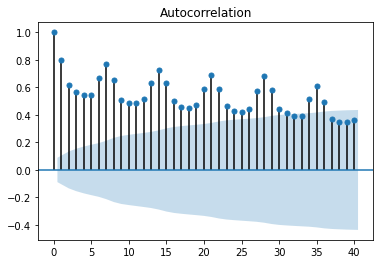

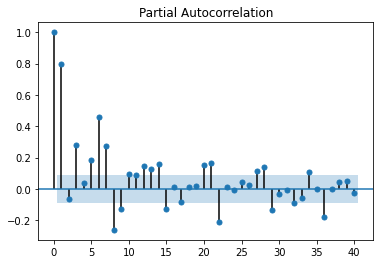

In [229]:
# Now let's plot the acf and pacf at different lags
title = 'Autocorrelation'
lags = 40
plot_acf(pre_views['views'],title=title,lags=lags);

title='Partial Autocorrelation'
lags=40
plot_pacf(pre_views['views'],title=title,lags=lags);

In [78]:
auto_arima(pre_views['views'], start_p=0, start_q=0,test='adf',
                           max_p=3, max_q=3, m=7,
                           start_P=0,start_Q=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  490
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -6325.340
Date:                                Mon, 06 Jul 2020   AIC                          12660.680
Time:                                        05:22:31   BIC                          12681.570
Sample:                                             0   HQIC                         12668.890
                                                - 490                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -343.1608    918.250     -0.374      0.709   -2142.899    1456.577
ma.L1         -0.1284      0.031     -4.120      0.000      -0.190      -0.067
ma.S.L7       -0.6140      0.037    -16.388      0.000      -0.687      -0.541
ma.S.L14      -0.2794      0.023    -11.957      0.000      -0.325      -0.234
sigma2      1.975e+10      0.000   1.85e+14      0.000    1.97e+10    1.97e+10
===================================================================================
Ljung-Box (Q):                       78.98   Jarque-Bera (JB):               542.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.27e+29. Standard errors may be unstable.
"""

                                       SARIMAX Results                                        
Dep. Variable:                                  views   No. Observations:                  490
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -6325.669
Date:                                Tue, 07 Jul 2020   AIC                          12659.338
Time:                                        01:38:45   BIC                          12676.050
Sample:                                    07-01-2015   HQIC                         12665.906
                                         - 11-01-2016                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1271      0.031     -4.081      0.000      -0.188      -0.066
ma.

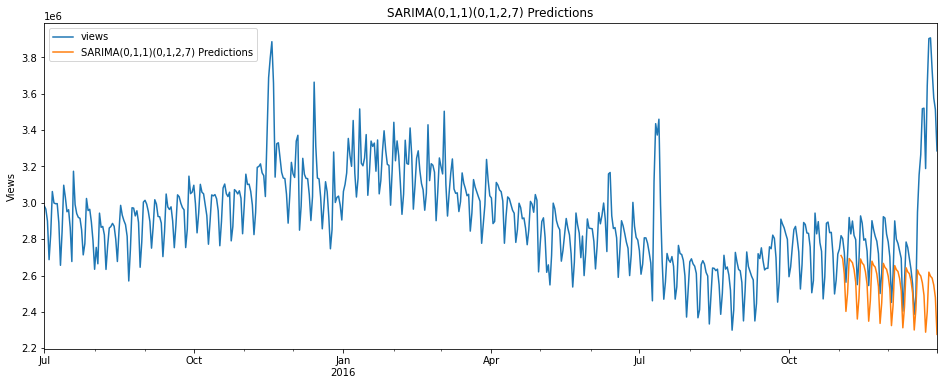

RMSE = 491075.8698601798
MAPE = 10.706872597856727


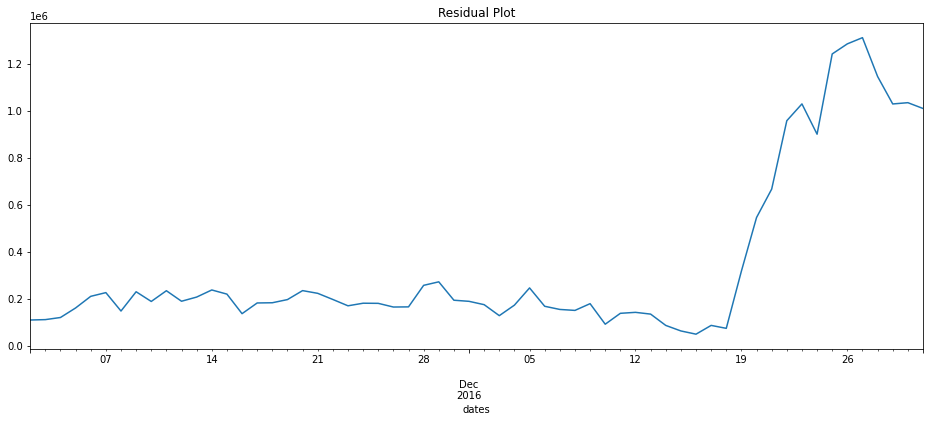

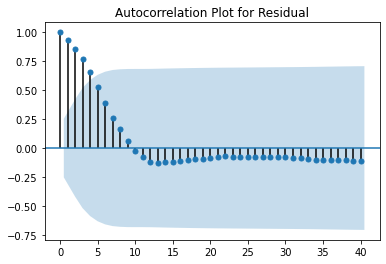

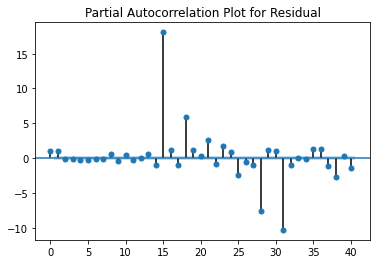

In [230]:
pred_resid=SARIMAX_fit(0,1,1,0,1,2,7)

In [82]:
adf_p_value=statsmodels.tsa.stattools.adfuller(pred_resid[1])

if (adf_p_value[1]>0.05):
    print('p-value is {p} which is more than 0.05. So this time series is non-stationary'.format(p=adf_p_value[1]))
else:
    print('p-value is {p} which is less than 0.05. So this time series is stationary'.format(p=adf_p_value[1]))

p-value is 0.6356747122791246 which is more than 0.05. So this time series is non-stationary


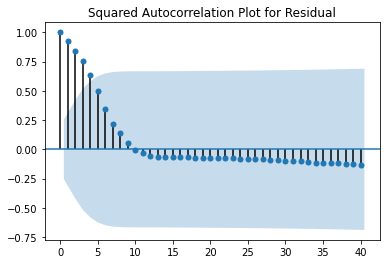

In [83]:
sq_resid=(np.array(pred_resid[1]))*(np.array(pred_resid[1]))

title = 'Squared Autocorrelation Plot for Residual'
lags = 40
plot_acf(sq_resid,title=title,lags=lags);   

#### SARIMA Performance for some extreme cases:
* 70771 - article views with large linear slope - MAPE = 13.871873287384853%
* 108340 - article views with large linear slope - MAPE = 11.74985115596561%
* 95855 - article views with least slope or article which going down - MAPE = 7.458505526315471%
* 139119 - article with high average views - MAPE = 10.706872597856727%

# Prophet
Prophet is an open-source time series forecasting tool developed by Facebook. It is implemented in an R library, and also a Python package.

Prophet works as an additive regression model which decomposes a time series into (i) a (piecewise) linear/logistic trend, (ii) a yearly seasonal component, (iii) a weekly seasonal component, and (iv) an optional list of important days (such as holidays, special events, …). It claims to be “robust to missing data, shifts in the trend, and large outliers”, which would make it well suited for this particular task.

<Strong>Reading Reference</strong>

We can read the paper for Prophet! It has a lot of insight on their techniques on how Prophet works internally!

Link to paper: https://peerj.com/preprints/3190.pdf

#### Basic performance

In [231]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation,performance_metrics
from fbprophet.plot import plot_cross_validation_metric

##### Predict for rowname = 139119 ( article with high average views ) - Prophet

In [232]:
rownr = 139119

pageviews=extract_ts(rownr)

#prophet expects the folllwing label names
pageviews.rename(columns={"dates": "ds", "views": "y"},inplace=True)

pred_len = 60
pred_range = [pageviews.shape[0]-pred_len+1, pageviews.shape[0]]
pre_views = pageviews.head(pageviews.shape[0]-pred_len)
post_views = pageviews.tail(pred_len)

proph = Prophet(yearly_seasonality=True,daily_seasonality=False)
proph.fit(pre_views)
future = proph.make_future_dataframe(periods = pred_len)
fcast = proph.predict(future)

A few notes about the practical workings of prophet:

1. data format: prophet expects a data frame with two columns: ds, y. The first one holds the dates, the second one the time series counts.

2. parameter changepoint_prior_scale adjusts the trend flexibility. Increasing this parameter makes the fit more flexible, but also increases the forecast uncertainties and makes it more likely to overfit to noise. The changepoints in the data are automatically detected unless being specified by hand using the changepoints argument (which we don’t do here).

3. parameter yearly_seasonality=TRUE has to be enabled explicitely and allows prophet to notice large-scale cycles. The importance of this parameter is explored further below.

This is the standard prophet forecast plot:

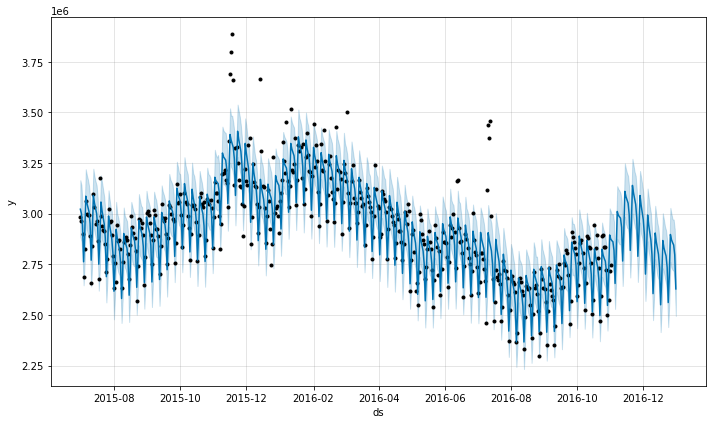

In [233]:
proph.plot(fcast);

The observed data are plotted as black points and the fitted model, plus forecast, as a blue line. In light blue we see the corresponding uncertainties.

Prophet offers a decomposition plot, where we can inspect the additive components of the model: trend, yearly seasonality, and weekly cycles:

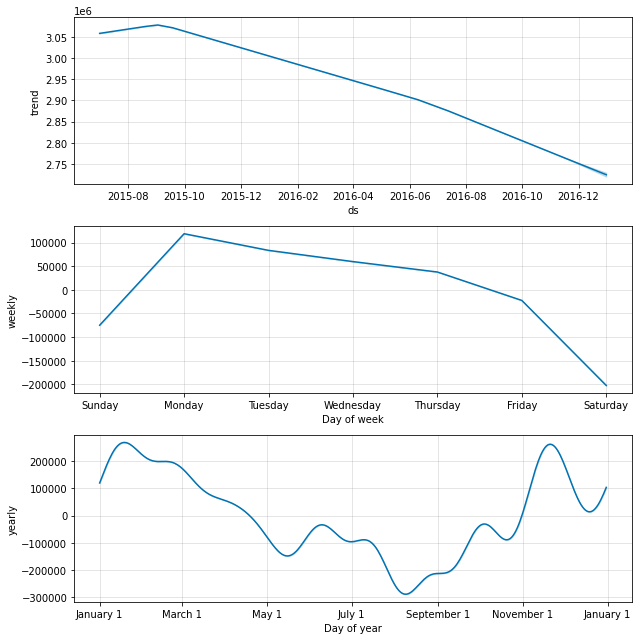

In [234]:
proph.plot_components(fcast);

In [235]:
def prophet_fit(rownr):
    pageviews=extract_ts(rownr)

    #prophet expects the folllwing label names
    pageviews.rename(columns={"dates": "ds", "views": "y"},inplace=True)

    pred_len = 60
    pred_range = [pageviews.shape[0]-pred_len+1, pageviews.shape[0]]
    pre_views = pageviews.head(pageviews.shape[0]-pred_len)
    post_views = pageviews.tail(pred_len)

    proph = Prophet(yearly_seasonality=True,daily_seasonality=False)
    proph.fit(pre_views)
    future = proph.make_future_dataframe(periods = pred_len)
    fcast = proph.predict(future)

    proph.plot(fcast);

    ax=pageviews.plot(x='ds',y='y',label='Actual Views',legend=True,figsize=(16,6))
    fcast[-60:].plot(x='ds',y='yhat',label='Prophet Predictions (views)',legend=True,ax=ax,)
    
    # Initial 365 days training period
    initial = 1 * 365
    initial = str(initial) + ' days'
    # Fold every 30 days
    period = 30
    period = str(period) + ' days'
    # Forecast 60 days into the future
    horizon = 60
    horizon = str(horizon) + ' days'
    
    pageviews_cv = cross_validation(proph, initial=initial, period=period, horizon = horizon)
    
    plot_cross_validation_metric(pageviews_cv, metric='rmse');
    plot_cross_validation_metric(pageviews_cv, metric='mape');

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-07-04 00:00:00 and 2016-09-02 00:00:00


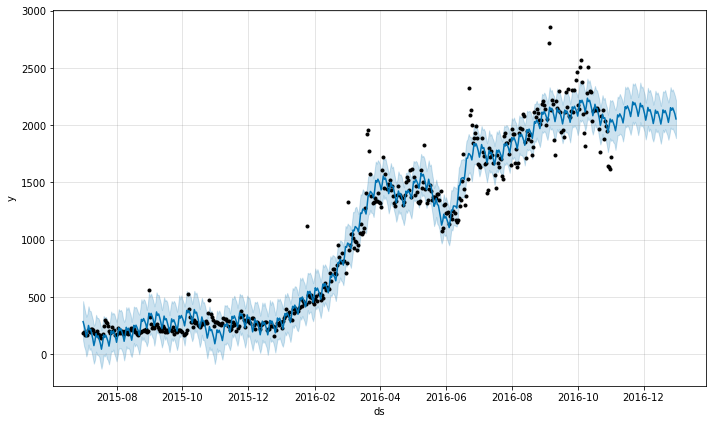

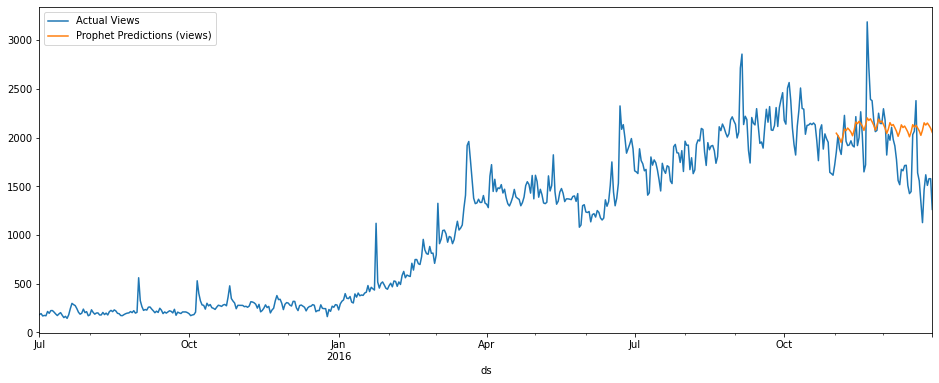

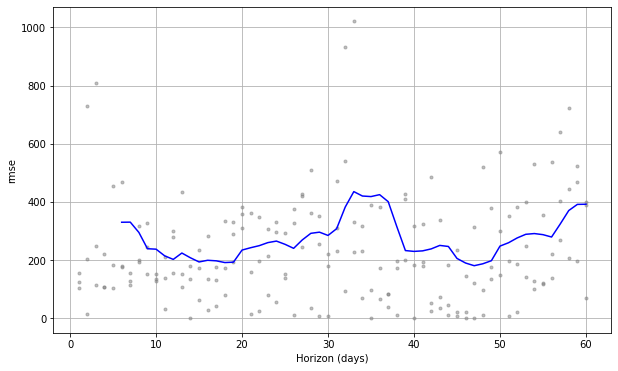

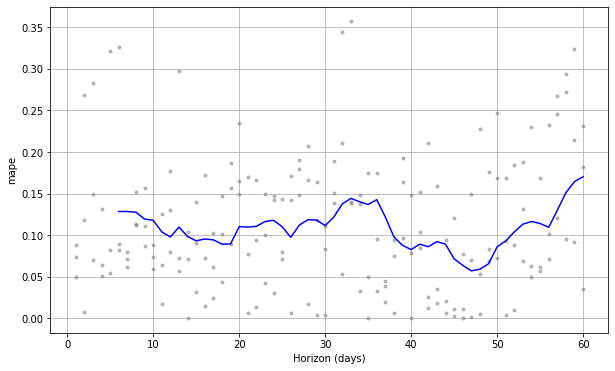

In [236]:
prophet_fit(70771)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-07-04 00:00:00 and 2016-09-02 00:00:00


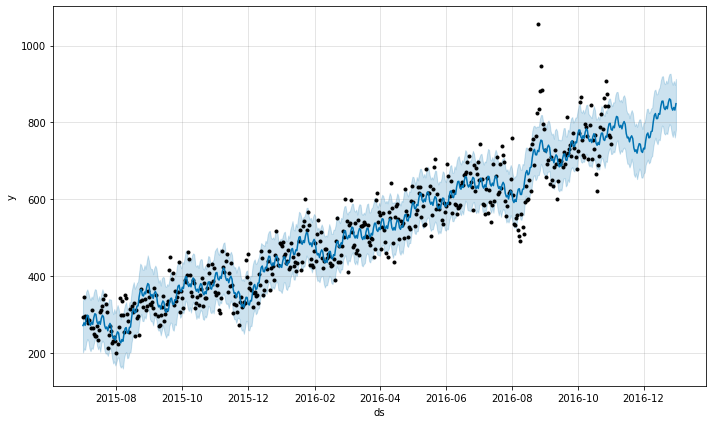

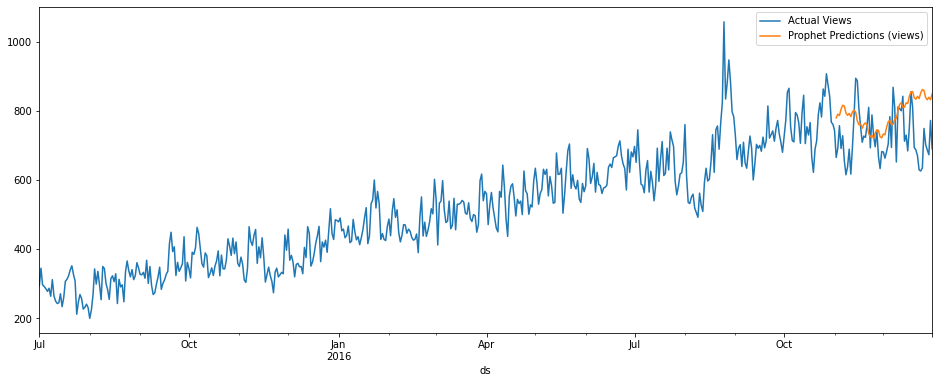

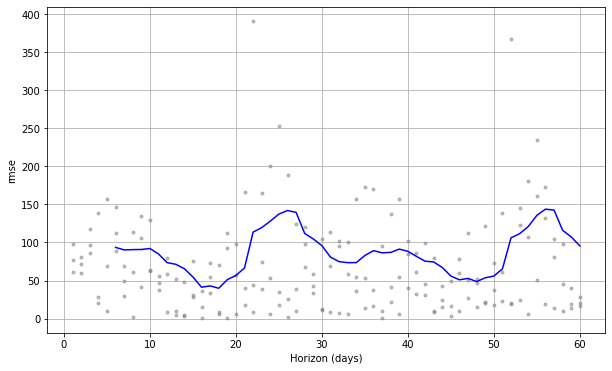

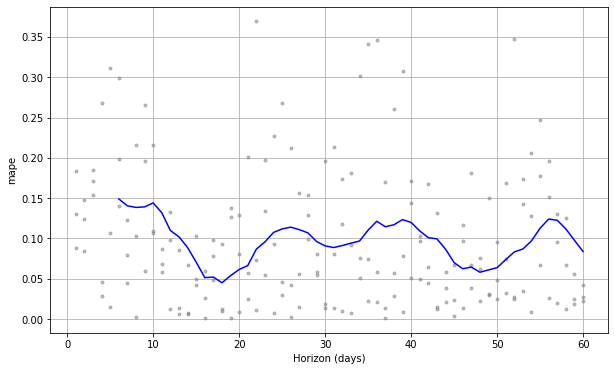

In [237]:
prophet_fit(108340)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-07-04 00:00:00 and 2016-09-02 00:00:00


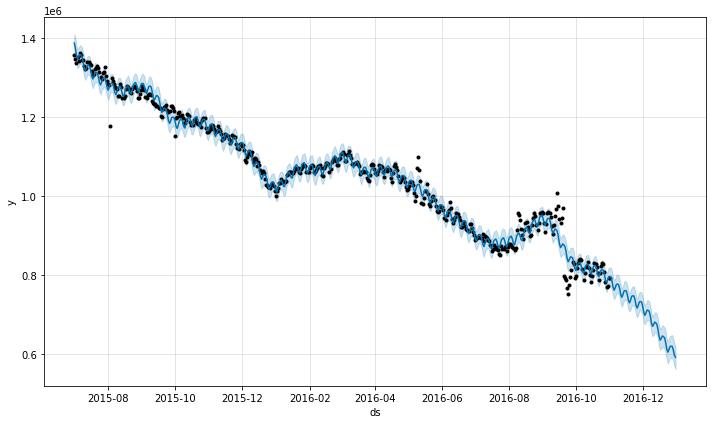

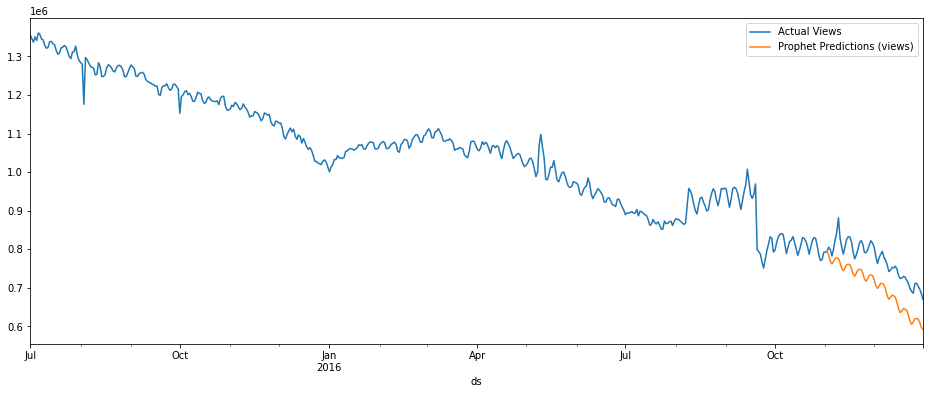

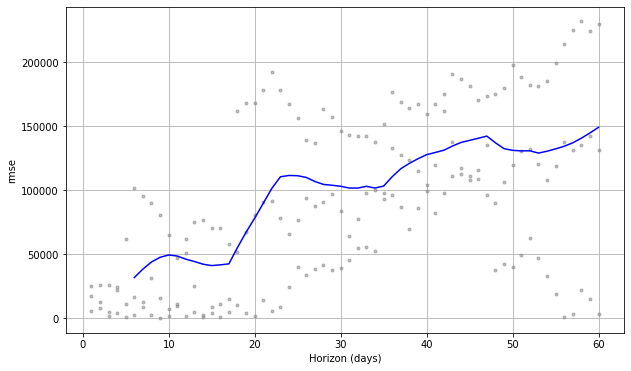

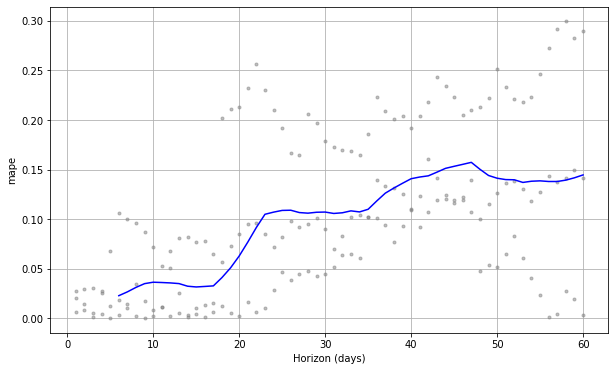

In [238]:
prophet_fit(95855)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-07-04 00:00:00 and 2016-09-02 00:00:00


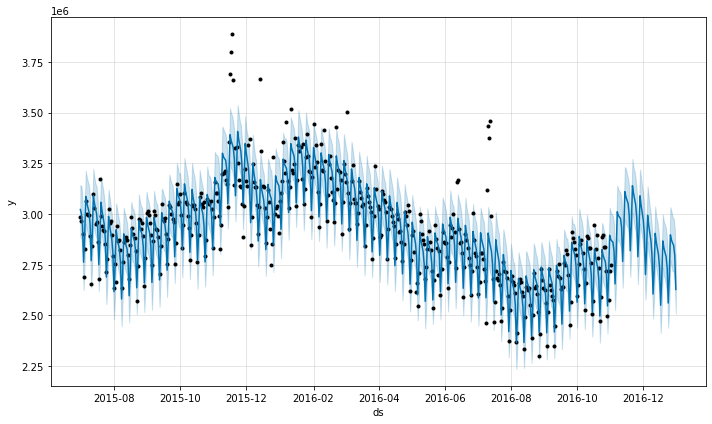

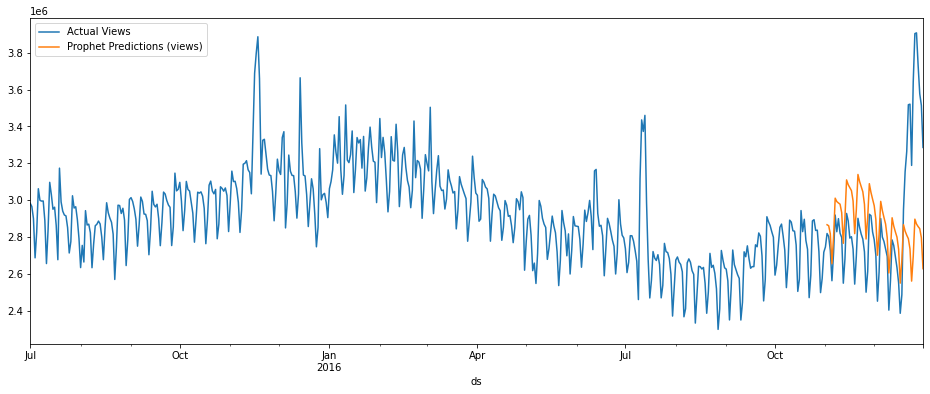

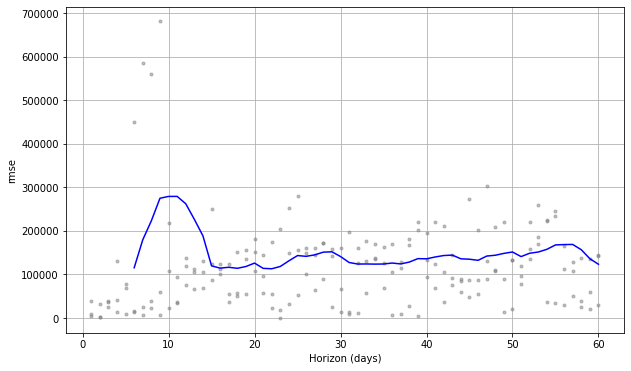

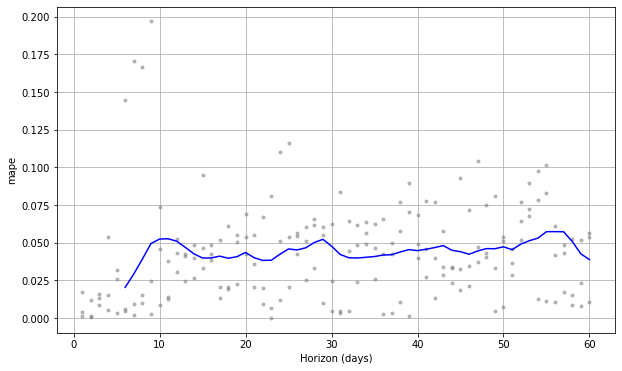

In [239]:
prophet_fit(139119)

#### Prophet Performance for some extreme cases:
* 70771 - article views with large linear slope - MAPE = 16%
* 108340 - article views with large linear slope - MAPE = 8%
* 95855 - article views with least slope or article which going down - MAPE = 14%
* 139119 - article with high average views - MAPE = 4%